# **Implementing a Quantum-Classical Parameter Mapping**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import math
import re
from numba import njit
from itertools import product
from scipy.linalg import kron
from typing import Tuple, Optional, Dict, List
from numba.typed import List

In this Jupyter notebook, we aim to numerically analyze the mapping of parameters between a QM Equilibrium Ising model and a dynamical classical Ising model. The Quantum Boltzmann Machine [1]. It can be used to encode classical data, as described in [2]. The Boltzmann machine and general info on dynamics and inverse mapping can be found in [3].

<center><img src="https://github.com/ringo333/QBM-code/blob/develop/Figures/Theory/Quantum%20Classical%20Mapping%20Diagram.drawio(2)(1).drawio(2).png?raw=true"/></center>

Each of the arrows in this corresponds to a Python function we will need to build to perform the mapping. We start by creating functions for the two leftmost arrows.  

[1] Amin, Mohammad H., et al. "Quantum boltzmann machine." Physical Review X 8.2 (2018): 021050.  
[2] Kappen, Hilbert J. "Learning quantum models from quantum or classical data." Journal of Physics A: Mathematical and Theoretical 53.21 (2020): 214001.  
[3] Nguyen, H. Chau, Riccardo Zecchina, and Johannes Berg. "Inverse statistical problems: from the inverse Ising problem to data science." Advances in Physics 66.3 (2017): 197-261.

## **Obtaining a valid transition matrix**

First off, we aim to simulate the following dynamical system:

$W\left(s^{\prime} \mid s\right)=W(s \mid s) \delta_{s^{\prime}, s} + \sum_{i} g_{i}(s) \delta_{s^{\prime}, F_{i}[s]} +  \sum_{ij} g_{ij}(s) \delta_{s^{\prime}, F_{ij}[s]}$

In this formulation, $g_i$ and $g_{ij}$ represent the probabilities of single and double spin flips respectively, whereas $F_i[]$ acts as the flip operator, which inverts the spin 'i' of a given state 's'. The indices i and j in this context denote the specific bits of the spin state to be flipped. The additional parameter $w$ allows us to adjust the time-scales associated with the spin flips without impacting the steady-state distribution. Please note that this parameter matrix $w$ needs to be symmetric, for instance, $w_{12} = w_{21}$. This is because flipping bits 1 and 2 is equivalent to flipping bits 2 and 1.

We can express the explicit flip probabilities as:

$g_i(s)=\exp \left[-w_{i i}-s_i\left(h_i+\sum_{i \neq j} J_{i j} s_j\right)\right]$

$g_{ij}(s) = \exp \left(-w_{ij}+J_{ij} s_is_j - s_i \left[\sum_{i} J_{ik} s_k + h_i \right] - s_j \left[ \sum_{i'} J_{jk'} s_{k'} + h_j \right] \right)$

The diagonal entries $W(s \mid s)$ are defined as $ 1 - \sum_{s'} W(s \mid s')$. In this context, the parameters $w$ establish the normalization of the self-transitions and should be selected such that $W(s \mid s) > 0$.

Using these dynamics, we can derive a transition matrix. Here, the row entries indicate the initial state of the system, while the column entries represent the target state. The matrix entries themselves correspond to the respective transition probabilities. Each row of the transition matrix is normalized. The spin states {-1,1} are mapped to binary {0,1}, with the leftmost bit corresponding to the first spin.

As an example, for a system with three spins, the explicit transition matrix could be presented as follows:

$$W = \begin{pmatrix}
W(000|000) & g_1(000) & g_2(000) & g_{12}(000) & g_3(000) & g_{13}(000) & g_{23}(000) & 0 \\
g_1(001) & W(001|001) & g_{12}(001) & g_2(001) & g_{13}(001) & g_3(001) & 0 & g_{23}(001) \\
g_2(010) & g_{12}(010) & W(010|010) & g_1(010) & g_{23}(010) & 0 & g_3(010) & g_{13}(010) \\
g_{12}(011) & g_2(011) & g_1(011) & W(011|011) & 0 & g_{23}(011) & g_{13}(011) & g_3(011) \\
g_3(100) & g_{13}(100) & g_{23}(100) & 0 & W(100|100) & g_1(100) & g_2(100) & g_{12}(100) \\
g_{13}(101) & g_3(101) & 0 & g_{23}(101) & g_1(101) & W(101|101) & g_{12}(101) & g_2(101) \\
g_{23}(110) & 0 & g_3(110) & g_{13}(110) & g_2(110) & g_{12}(110) & W(110|110) & g_1(110) \\
0 & g_{23}(111) & g_{13}(111) & g_3(111) & g_{12}(111) & g_2(111) & g_1(111) & W(111|111) \\
\end{pmatrix}$$



In [2]:
###  CONVERTING SPIN <-> BINARY FUNCTIONS
#----------------------------------------------------------------------
@njit
def index_to_spin_state(s_idx: int, N: int) -> np.ndarray:
    """Convert an index to a spin state."""
    s = np.zeros((N,), dtype=np.int64)
    for i in range(N):
        # get the ith bit of s_idx.
        bit = (s_idx >> i) & 1
        # convert the bit to a spin (-1 or 1).
        s[N - 1 - i] = bit * 2 - 1
    return s

@njit
def spin_state_to_index(s: np.ndarray) -> int:
    """Convert a spin state to an index."""
    N = len(s)
    s_idx = 0
    for i in range(N):
        # convert the spin to a bit (0 or 1).
        bit = (s[i] + 1) // 2
        # set the ith bit of s_idx.
        s_idx |= bit << (N - 1 - i)
    return s_idx

@njit
def bits_flipped_indices(s_idx: int, flip_index: int, N: int) -> List[int]:
    """Return the indices of the bits that are flipped when going from s_idx to flip_index."""
    flipped_bits = s_idx ^ flip_index
    flipped_indices = []
    for k in range(N):
        if (flipped_bits & (1 << k)) != 0:
            flipped_indices.append(N - 1 - k)
    return flipped_indices

@njit
def steady_state(A):
    """Calculates the steady state of a (left) stochastic matrix"""
    # compute eigenvalues and corresponding eigenvectors for the transposed matrix
    eigenvalues, eigenvectors = np.linalg.eig(A.T)
    
    # get the eigenvector corresponding to eigenvalue 1 (the steady state)
    steady_state = np.abs(np.real(eigenvectors[:, np.argmax(np.real(eigenvalues))]))
    
    # normalize the vector to get a probability distribution
    steady_state = steady_state / np.sum(steady_state)
    
    return steady_state.flatten()

In [3]:
### AUXILARY SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def g_single(i: int, s: np.ndarray, w: np.ndarray, h: np.ndarray, J: np.ndarray):
    """Calculates the single flip probability."""
    sum_Js = np.sum(J[i, :] * s)
    return np.exp(-w[i, i] - s[i] * (h[i] + sum_Js))

@njit
def g_double(i: int, j: int, s: np.ndarray, w: np.ndarray, h: np.ndarray, J: np.ndarray):
    """Calculates the double flip probability"""
    sum_Js_i = np.sum(J[i, :] * s) - J[i, j] * s[j]
    sum_Js_j = np.sum(J[j, :] * s) - J[i, j] * s[i]

    return np.exp(-w[i, j] + J[i, j] * s[i] * s[j] - s[i] * (sum_Js_i + h[i]) - s[j] * (sum_Js_j + h[j]))

@njit
def choice(probabilities: np.ndarray) -> int:
    """A workaround for np.random.choice, which is unsupported by numba"""
    cumulative_distribution = np.cumsum(probabilities)
    return np.searchsorted(cumulative_distribution, np.random.random(), side ="right")

In [4]:
@njit
def compute_transition_matrix(w: np.ndarray, h: np.ndarray, J: np.ndarray) -> np.ndarray:
    """Computes the transition matrix for the given parameters."""
    N = len(h)  # number of spins in the lattice
    transition_matrix = np.zeros((2**N, 2**N))

    #sum over rows to fill
    for s_idx in range(2**N):
        s = index_to_spin_state(s_idx, N)
        flip_probs = np.zeros((2**N))  # initialize with zeros

        for i in range(N):
            flip_index = s_idx ^ (1 << i)
            i_flipped = bits_flipped_indices(s_idx, flip_index, N)[0]
            flip_probs[flip_index] = g_single(i_flipped, s, w, h, J)  # single flip probabilities

        for i in range(N):
            for j in range(i+1, N):
                flip_index = s_idx ^ (1 << i) ^ (1 << j)
                i_flipped, j_flipped = bits_flipped_indices(s_idx, flip_index, N)
                flip_probs[flip_index] = g_double(i_flipped, j_flipped, s, w, h, J)  # double flip probabilities

       # add the no-flip probability and store the flipping probabilities
        no_flip_prob = 1 - sum(flip_probs)
        flip_probs[s_idx] = no_flip_prob
        transition_matrix[s_idx] = flip_probs

    return transition_matrix

### Testing the classical dynamics
**We now effectively can simulate the dynamics given the classical parameters $w$, $J$ and $h$. Let's do some checks.**  

In [5]:
### CONVERSION TEST FUNCTIONS
#----------------------------------------------------------------------
def test_spin_index_conversion(N):
    """Test that the conversion functions between spin states and indices are correct."""
    for s_idx in range(2**N):
        s = index_to_spin_state(s_idx, N)
        assert spin_state_to_index(s) == s_idx, "Conversion failed for index " + str(s_idx)

def test_bits_flipped_indices():
    """Test that bits_flipped_indices correctly identifies the indices of flipped bits."""
    N = 5  # number of bits in the binary representation

    # test with a few manually created examples
    examples = [
        # s_idx, flip_index, expected_flipped_indices
        (0b00000, 0b00001, [4]),
        (0b00000, 0b00010, [3]),
        (0b00000, 0b00100, [2]),
        (0b00000, 0b01000, [1]),
        (0b00000, 0b10000, [0]),
        (0b10101, 0b11111, [3,1]),
        (0b10101, 0b10001, [2]),
        (0b00000, 0b11111, [4, 3, 2, 1, 0]),
        (0b11111, 0b00000, [4, 3, 2, 1, 0]),
        (0b11111, 0b11111, []),
    ]
    for s_idx, flip_index, expected in examples:
        result = bits_flipped_indices(s_idx, flip_index, N)
        assert result == expected, f"For s_idx={bin(s_idx)}, flip_index={bin(flip_index)}, expected {expected} but got {result}"

def test_steady_state():
    """Test if the steady state function behaves as expected."""
    # stochastic transition matrix
    A = np.array([
        [0.7, 0.1, 0.1, 0.1],
        [0.2, 0.5, 0.2, 0.1],
        [0.2, 0.1, 0.6, 0.1],
        [0.2, 0.2, 0.2, 0.4]])

    # compute steady state
    p = steady_state(A)

    print(f"p is found to be: {p}")
    print(f"A @ p_computed = {np.dot(A.T,p)}")

    # check that p is a probability distribution
    assert np.all(p >= 0), "Probabilities should be non-negative."
    assert np.isclose(np.sum(p), 1), "Probabilities should sum to 1."

    # check that p is the steady state of A. this is done by checking if Ap = p
    assert np.allclose(np.dot(A.T, p), p, atol=1e-6), "Ap should equal p for steady state."

In [6]:
#check if conversion functions work as intended
test_bits_flipped_indices()
test_spin_index_conversion(N = 5)
test_steady_state()

print(f"Spin state corresponding to index 5:   {index_to_spin_state(5,3)}")
print(f"Index corresponding to state[ 1 -1  1]: {spin_state_to_index(np.array([1, -1, 1]))}")
print("All tests passed!")

p is found to be: [0.4        0.19047619 0.26666667 0.14285714]
A @ p_computed = [0.4        0.19047619 0.26666667 0.14285714]
Spin state corresponding to index 5:   [ 1 -1  1]
Index corresponding to state[ 1 -1  1]: 5
All tests passed!


Perform checks if w gives rise to a properly normalized self interaction (w has to be large enough such that no_flip_prob = 1 - other_probs > 0 ) and check if it has no influence on the steady-state distribution.

In [7]:
def test_w_effect_on_steady_state(w, J, h):
    """Check if the values of the self-interactions alter the steady state distribution of W"""
    # get initial transition matrix
    W = compute_transition_matrix(w, h, J)

    # get the initial steady state
    initial_ss = steady_state(W)
    
    # adjust the parameter matrix
    adjusted_w = w + np.ones(w.shape) * 5
    adjusted_w = (adjusted_w + adjusted_w.T) / 2 #make sure w is symmetric
    
    # generate new transition matrix based on adjusted_w (not provided)
    adjusted_W = compute_transition_matrix(adjusted_w, h, J)
    
    # get the adjusted steady state
    adjusted_ss = steady_state(adjusted_W)
    
    # check if the steady states are similar using a tolerance level
    assert np.allclose(initial_ss, adjusted_ss, atol=1e-5), f"Steady states are different! \n Initial steady state: \n {initial_ss},\n Adjusted steady state: \n {adjusted_ss} \n Absolute difference: \n {np.abs(initial_ss - adjusted_ss)}"
    

def check_w(w, h, J, step_size = 1e-4, no_flip_prob = 0):
    """Checks if w gives rise to a proper normalized W. Prints the minimal value of w required if it's not the case"""
    min_scalar = 0
    W = compute_transition_matrix(w, h, J)
    self_probs = np.diag(W.copy())

    if np.all(self_probs >= no_flip_prob):
        return
    else:
        self_probs_old = self_probs.copy()
        while True:
            new_w             = w + np.ones(w.shape) * min_scalar
            W = compute_transition_matrix(new_w, h, J)
            self_probs        = np.diag(W)

            # check if the self-transition probabilities are all at least no_flip_prob
            if np.all(self_probs >= no_flip_prob):
                break

            # if the condition is not met, increase the scalar value and try again
            min_scalar += step_size

        assert np.all(self_probs_old >= no_flip_prob), f"Need to use larger w matrix: \n {new_w} "

In [8]:
# initialize the parameters
N = 3

w = np.array([[4, 4 ,4],
              [4, 4, 4],
              [4, 4, 4]], dtype = np.float64)

J = np.array([[0, 1, 1],
              [1 ,0, 1],
              [1, 1, 0]], dtype = np.float64)

h = np.array([0, 0, 0],   dtype = np.float64)

#run the tests
test_steady_state()
check_w(w, h, J)
test_w_effect_on_steady_state(w, J, h)

print("All tests passed!")

p is found to be: [0.4        0.19047619 0.26666667 0.14285714]
A @ p_computed = [0.4        0.19047619 0.26666667 0.14285714]
All tests passed!


Later on, it will be useful to have a function that checks if the input parameters are valid and give rise to a valid transition matrix that satisfies detailed balance:

In [9]:
def check_parameters(w, J, h):
    """Check if parameters are chosen to give rise to a normalized W that satisfies detailed balance"""
    check_w(w, h, J)
    assert np.allclose(J, J.T) and np.allclose(w, w.T) and np.all(J.diagonal() == 0),  "Input matrices w and J should be symmetric and J should have a zero diagonal"


def check_detailed_balance(W):
    """
    Check if the transition matrix W and stationary distribution pi satisfy the detailed balance condition.
    """
    pi = steady_state(W)
    n_states = W.shape[0]
    for i in range(n_states):
        for j in range(n_states):
            assert np.isclose(W[i, j] * pi[i], W[j, i] * pi[j]), "Transition matrix does not satisfy detailed balance"


def test_transition_matrix(W):
    """Test that the sum of the probabilities in each row of the transition matrix is 1 and there are no negative elements."""
    for row in W:
        assert np.isclose(np.sum(row), 1), "Row sums to " + str(np.sum(row))
        assert np.all(row >= 0), "Negative probability in row " + str(row)

In [10]:
# initialize the parameters
N = 3

w = np.array([[6, 6 ,6],
              [6, 6, 6],
              [6, 6, 6]], dtype = np.float64)

J = np.array([[0, 1, 1],
              [1 ,0, 1],
              [1, 1, 0]], dtype = np.float64)

h = np.array([1, 1, 1],   dtype = np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

#check if the transition matrix is valid
W = compute_transition_matrix(w, h, J)

#check validity of W
check_detailed_balance(W)
test_transition_matrix(W)

print("All tests passed!")

All tests passed!


#### We also want to check if the transition matrix is properly Boltzmann distributed:

In [11]:
### CONVEREGENCE TO BOLTZMANN HELPER FUNCTIONS
#----------------------------------------------------------------------
def energy(s, J, h):
    """ Compute the Ising energy of the system in a particular spin state. """
    s = s.astype(np.float64)                             # convert the spin configuratio to float64 for numba
    pairwise_energy = 1/2 * np.dot(s, np.dot(J, s))
    local_field_energy = h * s                            # simple multiplication for scalar-array operation
    return -pairwise_energy - np.sum(local_field_energy)  # sum over local field energy

def boltzmann_distribution(J, h):
    """Computes the Boltzmann probabilities of each state for the J and h parameters"""
    N = len(h)
    all_states = np.array([index_to_spin_state(s_idx, N) for s_idx in range(2**N)])
    energies = np.array([energy(state, J, h) for state in all_states])
    probabilities = np.exp(-energies)
    Z = np.sum(probabilities)
    return probabilities / Z

def plot_exact_probabilities(p, boltzmann_probs):
    n_spins = int(np.log2(len(p)))
    
    # prepare the state labels
    state_labels = ["".join("\u2191" if s == 1 else "\u2193" for s in index_to_spin_state(s_idx, n_spins)) for s_idx in range(2**n_spins)]
    x = np.arange(len(state_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.bar(x - width / 2, boltzmann_probs, width, label='Boltzmann', color='SteelBlue', alpha=0.8)
    ax.bar(x + width / 2, p, width, label='W steady state', color='Coral', alpha=0.8)

    ax.set_ylabel('Probability')
    ax.set_xlabel('Spin states')
    ax.set_title('Boltzmann vs Exact Steady State Probabilities')
    ax.set_xticks(x)
    ax.set_xticklabels(state_labels)
    ax.legend()

    plt.show()


### CONVEREGENCE TO BOLTZMANN TEST
#----------------------------------------------------------------------
def test_boltzmann_convergence(W, J, h, tolerance=1e-6):
    """ Test if the steady state probabilities obtained from the transition matrix match the Boltzmann distribution probabilities."""
    #check if we use correct parameters
    check_parameters(w, J, h)

    # get the transition matrix
    W = compute_transition_matrix(w, h, J)

    # get the steady state distribution
    p = steady_state(W)

    # compute the Boltzmann distribution probabilities
    boltzmann_probs = boltzmann_distribution(J, h).flatten()

    # plot the convergence to the Boltzmann distribution
    plot_exact_probabilities(p, boltzmann_probs)
    
    # check if the two probability distributions are close
    assert np.allclose(p, boltzmann_probs, atol=tolerance), f"Difference between W steady state and Boltzmann distribution: \n {np.abs(p-boltzmann_probs)}"

#### Let's test for some different parameter values:

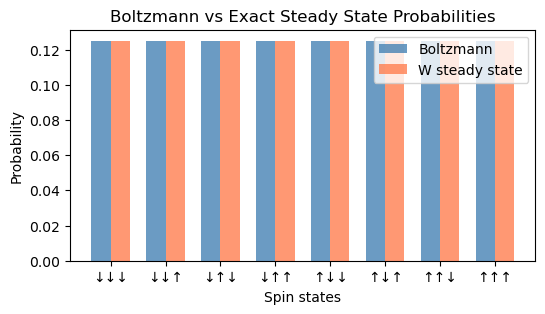

In [12]:
# initialize the parameters
N = 3
w = np.array([[2, 2 ,2],
              [2, 2, 2],
              [2, 2, 2]], dtype = np.float64)

J = np.array([[0, 0, 0],
              [0 ,0, 0],
              [0, 0, 0]], dtype = np.float64)

h = np.array([0, 0, 0],   dtype = np.float64)


#check convergence
test_boltzmann_convergence(W, J, h)

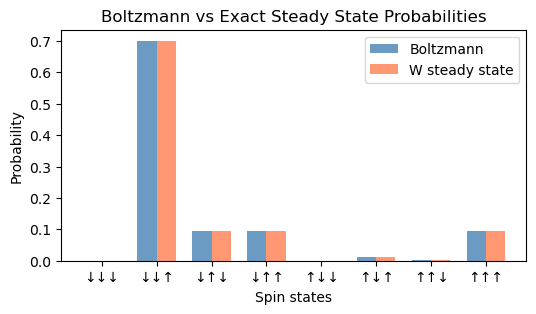

In [13]:
# initialize the parameters
N = 3
w = np.array([[8, 8, 8],
              [8, 8, 8],
              [8, 8, 8]], dtype = np.float64)

J = np.array([[0, 1, 1],
              [1 ,0, -2],
              [1, -2, 0]], dtype = np.float64)

h = np.array([-2, 2, 3],   dtype = np.float64)

#check convergence
test_boltzmann_convergence(W, J, h)

### Simulating the Transition matrix

In [14]:
###  SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def spin_flip(s: np.ndarray, transition_matrix: np.ndarray) -> np.ndarray:
    """ Flipping algorithm, uses precomputed transition matrix. """
    N = len(s)  # number of spins in the lattice

    # calculate the index of the current state in the transition matrix
    s_idx = spin_state_to_index(s)

    # get probabilities from transition matrix
    flip_probs = transition_matrix[s_idx]

    # randomly choose a spin flip according to its probability of occurring
    idx = choice(flip_probs)

    # apply the chosen spin flip
    flipped_indices = bits_flipped_indices(s_idx, idx, N)
    
    if len(flipped_indices)   == 0:  # no flip
        pass
    elif len(flipped_indices) == 1:  # single flip
        i = flipped_indices[0]
        s[i] *= -1
    elif len(flipped_indices) == 2:  # double flip
        i, j = flipped_indices
        s[i] *= -1
        s[j] *= -1

    return s

def spin_flip_w_print_statements(s: np.ndarray, transition_matrix: np.ndarray) -> np.ndarray:
    """ Flipping algorithm, uses precomputed transition matrix. """
    N = len(s)  # number of spins in the lattice

    # calculate the index of the current state in the transition matrix
    s_idx = spin_state_to_index(s)
    print(f"Spin state index: {s_idx}")  # Debugging print statement

    # get probabilities from transition matrix
    flip_probs = transition_matrix[s_idx]
    print(f"Flip probabilities: {flip_probs}")  # Debugging print statement

    # randomly choose a spin flip according to its probability of occurring
    idx = choice(flip_probs)
    print(f"Chosen index for flip: {idx}")  # Debugging print statement

    # apply the chosen spin flip
    flipped_indices = bits_flipped_indices(s_idx, idx, N)
    print(f"Indices to be flipped: {flipped_indices}")  # Debugging print statement

    # make a copy of the spin state
    s_new = s.copy()
    
    if len(flipped_indices)   == 0:  # no flip
        pass
    elif len(flipped_indices) == 1:  # single flip
        i = flipped_indices[0]
        s_new[i] *= -1
    elif len(flipped_indices) == 2:  # double flip
        i, j = flipped_indices
        s_new[i] *= -1
        s_new[j] *= -1

    print(f"Old state: {s}, New state: {s_new}")  # Debugging print statement
    return s_new


# @njit
def simulate_dynamics(W: np.ndarray, steps: int, N: int) -> np.ndarray:
    """Simulates the dynamics of the system for the given number of steps."""
    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(N)], dtype=np.int64) #initial config
    trajectory = np.empty((steps, N), dtype=np.int64)

    for t in range(steps):
        s = spin_flip(s, W)
        trajectory[t] = s

    return trajectory

Test if the spin-flip algorithm works as intended:

In [15]:
def spin_flip_test():
    N = 3 # number of spins
    steps = 10

    # get a random valid transition matrix
    W_random = np.array([
        [0.15, 0.05, 0.1 , 0.1 , 0.2, 0.1 , 0.3 , 0.0],
        [0.2 , 0.1 , 0.3 , 0.1 , 0.1, 0.1 , 0.0 , 0.1],
        [0.1 , 0.35, 0.1 , 0.05, 0.2, 0.0 , 0.1 , 0.1],
        [0.1 , 0.1 , 0.6 , 0.05, 0.0, 0.05, 0.05, 0.05],
        [0.05, 0.4 , 0.05, 0.0 , 0.2, 0.1 , 0.1 , 0.1],
        [0.05, 0.05, 0.0 , 0.05, 0.1, 0.4 , 0.3 , 0.05],
        [0.2 , 0.0 , 0.2 , 0.1 , 0.1, 0.1 , 0.2 , 0.1],
        [0.0 , 0.2 , 0.1 , 0.1 , 0.1, 0.1 , 0.2 , 0.2] ])
    
    test_transition_matrix(W_random)

    print(W_random)

    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(N)], dtype=np.int64) #initial config
    for t in range(steps):
        print(f"\nStep {t}:")
        s = spin_flip_w_print_statements(s, W_random)

spin_flip_test()


[[0.15 0.05 0.1  0.1  0.2  0.1  0.3  0.  ]
 [0.2  0.1  0.3  0.1  0.1  0.1  0.   0.1 ]
 [0.1  0.35 0.1  0.05 0.2  0.   0.1  0.1 ]
 [0.1  0.1  0.6  0.05 0.   0.05 0.05 0.05]
 [0.05 0.4  0.05 0.   0.2  0.1  0.1  0.1 ]
 [0.05 0.05 0.   0.05 0.1  0.4  0.3  0.05]
 [0.2  0.   0.2  0.1  0.1  0.1  0.2  0.1 ]
 [0.   0.2  0.1  0.1  0.1  0.1  0.2  0.2 ]]

Step 0:
Spin state index: 2
Flip probabilities: [0.1  0.35 0.1  0.05 0.2  0.   0.1  0.1 ]
Chosen index for flip: 1
Indices to be flipped: [2, 1]
Old state: [-1  1 -1], New state: [-1 -1  1]

Step 1:
Spin state index: 1
Flip probabilities: [0.2 0.1 0.3 0.1 0.1 0.1 0.  0.1]
Chosen index for flip: 0
Indices to be flipped: [2]
Old state: [-1 -1  1], New state: [-1 -1 -1]

Step 2:
Spin state index: 0
Flip probabilities: [0.15 0.05 0.1  0.1  0.2  0.1  0.3  0.  ]
Chosen index for flip: 0
Indices to be flipped: []
Old state: [-1 -1 -1], New state: [-1 -1 -1]

Step 3:
Spin state index: 0
Flip probabilities: [0.15 0.05 0.1  0.1  0.2  0.1  0.3  0.  ]
Chosen

#### Test is our simulation also converges to the Boltzmann distribution:

This were exactly calculated probabilities. Let's see if we simulate a time series data from our transition matrix, this also converges to the Boltzman probabilities:

In [16]:
def plot_convergence_to_boltzmann(J, h, trajectory):
    n_spins = len(h)
    boltzmann_probs = boltzmann_distribution(J, h).flatten()

    # count the occurrences of each unique spin state in the trajectory
    state_counts = {}
    for state in trajectory:
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            state_counts[state_tuple] += 1
        else:
            state_counts[state_tuple] = 1

    # calculate the empirical probabilities from the trajectory
    empirical_probs = np.zeros(2**n_spins)
    for idx, state in enumerate(np.array([index_to_spin_state(s_idx, N) for s_idx in range(2**n_spins)])):
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            empirical_probs[idx] = state_counts[state_tuple] / len(trajectory)

    # plot the Boltzmann probabilities and the empirical probabilities
    state_labels = [spin_state_to_index(state) for state in np.array([index_to_spin_state(s_idx, n_spins) for s_idx in range(2**n_spins)])]
    x = np.arange(len(state_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6, 3))
    rects1 = ax.bar(x - width / 2, boltzmann_probs, width, label='Boltzmann', color='SteelBlue', alpha=0.8)
    rects2 = ax.bar(x + width / 2, empirical_probs, width, label='Simulation', color='Coral', alpha=0.8)

    ax.set_ylabel('Probability')
    ax.set_xlabel('Spin states')
    ax.set_title('Boltzmann vs Simulation Probabilities')
    ax.set_xticks(x)
    ax.set_xticklabels(state_labels)
    ax.legend()

    plt.show()

### CONVEREGENCE TO BOLTZMANN TEST
#----------------------------------------------------------------------
def test_simulation_boltzmann_convergence(W, J, h, tolerance=1e-6):
    """ Test if the empirical simulation probabilities match the Boltzmann distribution probabilities."""
    #check if we use correct parameters
    check_parameters(w, J, h)

    # compute the Boltzmann distribution probabilities
    boltzmann_probs = boltzmann_distribution(J, h).flatten()

    # get the transition matrix
    W = compute_transition_matrix(w, h, J)

    # get the steady state distribution
    p = steady_state(W)

    # plot the convergence to the Boltzmann distribution
    trajectory = simulate_dynamics(W, 2**24, len(h))
    plot_convergence_to_boltzmann(J, h, trajectory)
    
    # check if the two probability distributions are close
    assert np.allclose(p, boltzmann_probs, atol=tolerance), f"Difference between W steady state and Boltzmann distribution: \n {np.abs(p-boltzmann_probs)}"

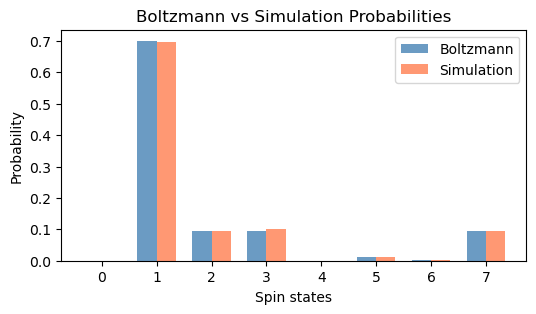

Test passed!


In [17]:
# initialize the parameters
N = 3
w = np.array([[8, 8, 8],
              [8, 8, 8],
              [8, 8, 8]], dtype = np.float64)

J = np.array([[0, 1, 1],
              [1 ,0, -2],
              [1, -2, 0]], dtype = np.float64)

h = np.array([-2, 2, 3],   dtype = np.float64)


# check if we got valid parameters
check_parameters(w, J, h)

# run the test
test_simulation_boltzmann_convergence(W, J, h, tolerance=1e-3)

print("Test passed!")

### Inferring W from a trajectory

We also want to be able to construct an empirical transition matrix, $W^{emp}$, from the time series data. This matrix captures the probabilities of transitioning between different states, as observed in the data.

In [18]:
@njit
def infer_transition_matrix(trajectory: np.ndarray) -> np.ndarray:
    """Infers the transition matrix from a time series of the states of the system"""
    N = trajectory.shape[1]  # number of spins in the lattice
    steps = trajectory.shape[0]  # number of steps in the trajectory
    transition_matrix = np.zeros((2**N, 2**N))

    for t in range(steps - 1):
        # convert the spin states to indices
        s_idx = spin_state_to_index(trajectory[t])
        next_s_idx = spin_state_to_index(trajectory[t + 1])

        # increment the corresponding cell in the transition matrix
        transition_matrix[s_idx, next_s_idx] += 1

    # normalize each row to get probabilities
    for i in range(2**N):
        row_sum = np.sum(transition_matrix[i])
        if row_sum > 0:  # avoid division by zero
            transition_matrix[i] /= row_sum

    return transition_matrix

##### Check if the empirical transition matrix converges to the exactly computed transition matrix over a long trajectory:

In [19]:
def test_infer_transition_matrix(W, N, steps):
    """Test that the empirical transition matrix converges to the model transition matrix for long trajectories."""
    
    # Simulate a trajectory of the system
    trajectory = simulate_dynamics(W, steps, N)

    # Infer the empirical transition matrix from the trajectory
    W_emp = infer_transition_matrix(trajectory)
    
    np.set_printoptions(precision=2, suppress=True)
    # Check that the empirical transition matrix is close to the model transition matrix
    assert np.allclose(W, W_emp, atol=1e-2), f"Empirical transition matrix does not match model transition matrix: \n W_emp: \n {W_emp} \n W: \n {W} \n Difference: \n {np.abs(W-W_emp)}"

In [20]:
N = 3

# get a random valid transition matrix
W_random = np.array([
    [0.15, 0.05, 0.1 , 0.1 , 0.2, 0.1 , 0.3 , 0.0],
    [0.2 , 0.1 , 0.3 , 0.1 , 0.1, 0.1 , 0.0 , 0.1],
    [0.1 , 0.35, 0.1 , 0.05, 0.2, 0.0 , 0.1 , 0.1],
    [0.1 , 0.1 , 0.6 , 0.05, 0.0, 0.05, 0.05, 0.05],
    [0.05, 0.4 , 0.05, 0.0 , 0.2, 0.1 , 0.1 , 0.1],
    [0.05, 0.05, 0.0 , 0.05, 0.1, 0.4 , 0.3 , 0.05],
    [0.2 , 0.0 , 0.2 , 0.1 , 0.1, 0.1 , 0.2 , 0.1],
    [0.0 , 0.2 , 0.1 , 0.1 , 0.1, 0.1 , 0.2 , 0.2] ])

# get a dynamics from parameters
w = np.array([[6.,6 ,6.],
              [6 ,6.,6.],
              [6.,6.,6.]])

J = np.array([[0,1,1],
              [1,0,1],
              [1,1,0]])
h = np.array([1, 1, 1])
check_parameters(w, J, h)
W_from_parameters = compute_transition_matrix(w, h, J)

# test if both transition matrices are valid ones
test_transition_matrix(W_random)
test_transition_matrix(W_from_parameters)

# run for both transition matrices
test_infer_transition_matrix(W_random, N, steps=2**24)
test_infer_transition_matrix(W_from_parameters, N, steps=2**26)
print("Test passed!")

AssertionError: Empirical transition matrix does not match model transition matrix: 
 W_emp: 
 [[0.98 0.   0.   0.01 0.   0.01 0.01 0.  ]
 [0.01 0.6  0.   0.01 0.   0.01 0.   0.38]
 [0.01 0.   0.61 0.01 0.   0.   0.01 0.37]
 [0.01 0.   0.   0.94 0.   0.   0.   0.05]
 [0.01 0.   0.   0.   0.62 0.01 0.01 0.36]
 [0.01 0.   0.   0.   0.   0.94 0.   0.05]
 [0.01 0.   0.   0.   0.   0.   0.94 0.05]
 [0.   0.   0.   0.   0.   0.   0.   1.  ]] 
 W: 
 [[0.98 0.   0.   0.01 0.   0.01 0.01 0.  ]
 [0.01 0.61 0.   0.01 0.   0.01 0.   0.37]
 [0.01 0.   0.61 0.01 0.   0.   0.01 0.37]
 [0.01 0.   0.   0.94 0.   0.   0.   0.05]
 [0.01 0.   0.   0.   0.61 0.01 0.01 0.37]
 [0.01 0.   0.   0.   0.   0.94 0.   0.05]
 [0.01 0.   0.   0.   0.   0.   0.94 0.05]
 [0.   0.   0.   0.   0.   0.   0.   1.  ]] 
 Difference: 
 [[0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.   0.   0.   0.   0.   0.01]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.01 0.   0.   0.01]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]

### Plotting the dynamics

In [21]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_combined_dynamics(trajectory, N):
    fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the system's evolution through states
    states = [(''.join(['0' if spin == -1 else '1' for spin in s])) for s in trajectory]  # convert spins to binary
    unique_states = sorted(set(states))
    state_indices = [unique_states.index(state) for state in states]
    
    ax1.step(range(len(state_indices)), state_indices)
    ax1.set_yticks(range(len(unique_states)))
    ax1.set_yticklabels(unique_states)
    ax1.set_title("System's evolution through states")
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('State')

    # Plot for the spins' evolution
    offset_labels = []
    y_ticks = []
    for i in range(N):
        spin_trajectory = trajectory[:, i] + i * 3
        ax2.step(range(len(spin_trajectory)), spin_trajectory, label=f'Spin {i+1}')
        offset_labels += ['0', '1']
        y_ticks += [(i*3 - 1), (i*3 +1)]
        
    ax2.set_title("Spins' evolution")
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Spin value (with offset)')
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels(offset_labels)
    ax2.legend(loc='best')
    ax2.plot()
    
    plt.tight_layout()
    plt.show()

We can visualize a dynamics as follows:

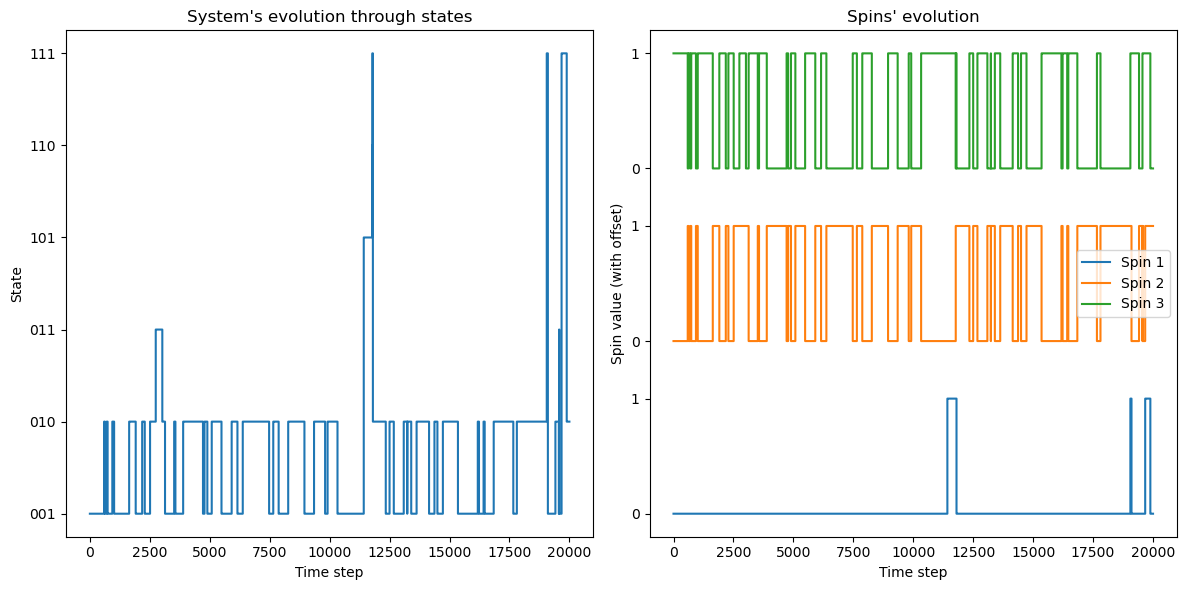

In [22]:
# classical parameters
w = np.array([[8, 8, 8],
              [8, 8, 8],
              [8, 8, 8]], dtype = np.float64)

J = np.array([[0, 1, 1],
              [1 ,0, -2],
              [1, -2, 0]], dtype = np.float64)

h = np.array([-2, 2, 2],   dtype = np.float64)

check_parameters(w, J, h)
# other parameters
N = 3
steps = 20000

W = compute_transition_matrix(w, h, J)
trajectory = simulate_dynamics(W, steps, N)
plot_combined_dynamics(trajectory, N)

## **Implementation of the Boltzmann Machine**

Our next goal is to be able to infer the parameters $w$, $J$ and $h$ from a time series data of our system.

Now we will need to be able to infer the classical parameters from the empirical transition matrix. This process requires more thought. We can always obtain the equilibrium distribution p(s) from the transition matrix by finding the eigenvector corresponding to the eigenvalue 1. From p(s), we can determine the parameters J and h using a classical Boltzmann machine to model the equilibrium distribution. We can obtain the clamped statistics from the transition matrix as follows: 
$$ \langle s_i \rangle _c = \sum_s s_i p(s) $$
$$ \langle s_i s_j \rangle _c = \sum_s s_i s_j p(s)$$

The clamped statistics can be used in the Boltzmann machine. 

In [23]:
###  BOLTZMANN MACHINE AUXILARY FUNCTIONS
#----------------------------------------------------------------------
def all_possible_configs(N: int) -> np.ndarray:
    '''Generates a 2^N by N matrix with all possible configurations of a binary spin system of size N'''
    configs = np.zeros((2**N,N))
    for i in range(2**N):
        config = np.array([1 if x == '1' else -1 for x in np.binary_repr(i, width=N)])
        configs[i] = config
    return configs

@njit
def calcEnergy(config: np.ndarray, J: np.ndarray, h: np.ndarray) -> float:
    '''Calculates the energy of a given configuration'''
    config_float = config.astype(np.float64)  # convert config to float
    energy = -np.dot(config_float.T, np.dot(J, config_float)) / 2 - np.dot(h, config_float)
    return energy

@njit
def calcMag(config: np.ndarray) -> float:
    ''' Magnetizations of a given configuration '''
    return np.sum(config)

@njit
def calcCorr(config: np.ndarray) -> np.ndarray: 
    '''Calculates the spin-spin correlations of a given configuration. Returns a NxN matrix with the correlations'''
    return np.outer(config, config.T)

@njit
def log_likelihood(p: np.ndarray, J: np.ndarray, h: np.ndarray, configs: np.ndarray) -> float:
    """Calculates the log-likelihood of the system under the Boltzmann distribution."""
    Z = 0
    for config in configs:
        Ene = calcEnergy(config, J, h)
        Z += np.exp(-Ene)
    logZ = np.log(Z)

    log_likelihood = 0
    for i, config in enumerate(configs):
        Ene = calcEnergy(config, J, h)
        log_likelihood += p[i] * (-Ene - logZ)

    return log_likelihood

In [24]:
###  BOLTZMANN MACHINE FUNCTIONS
#----------------------------------------------------------------------
@njit
def ising_solve_exact_simplified(N: int, J: np.ndarray, h: np.ndarray, configs: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:    
    '''Calculates the free statistics for a single temperature using exact calculation'''
    beta = 1.0
    Z, C1, C2  = 0, np.zeros((N)), np.zeros((N,N))    #  initialize arrays to store variables                       
                                           
    for config in configs:
        Ene  = calcEnergy(config,J,h)
        Corr = calcCorr(config) 
        p    = np.exp(-beta * Ene)                    #  non-normalized probability of this  configuration at this temperature
        Z  +=  p                                        
        C1 +=  p * config                               
        C2 +=  p * Corr

    Ci   = C1 / Z
    CiCj = C2 / Z
        
    return Ci,CiCj

@njit
def classical_boltzmann_machine(p: np.ndarray, N: int, configs: np.ndarray, maxiter: int, learning_rate: float, tol: float = 1e-14) -> Tuple[np.ndarray, np.ndarray, List[np.ndarray], List[np.ndarray], List[float]]:
    '''Solves the inverse Ising problem. Returns weight matrices that generated the clamped statistics 
    and the inferred weight matrix'''
    J_assym = 2.0 * np.random.random((N, N)) - 1.0   # random initial values between -1 and 1
    J = (J_assym+ J_assym.T)/2                       # symmetrize the random matrix 
    np.fill_diagonal(J, 0)                           # set diagonal of J to 0 to ensure detailed balance
    h = 2.0 * np.random.random(N) - 1.0              # random initial values between -1 and 1

    # compute the expected spin values
    Ci_clamp = np.dot(p, configs)

    # compute the expected spin-spin correlations
    CiCj_clamp = configs.T @ np.diag(p) @ configs
        
    #  initialize gradient ascent values  
    it    = 0
    delta_J = np.inf
    delta_h = np.inf
    # old_log_likelihood = -np.inf

    # initialize lists to store the values of the parameters and the log-likelihood at each iteration
    J_values = []
    h_values = []
    log_likelihood_values = []
    
    while (it < maxiter and (delta_J > tol or delta_h > tol)):    #  start gradient ascent
        it += 1

        #generate free statistics based on type of solver
        Ci_free, CiCj_free = ising_solve_exact_simplified(N, J, h, configs) 

        # compute the updates for J and h
        delta_J = learning_rate * (CiCj_clamp - CiCj_free)
        delta_h = learning_rate * (Ci_clamp   - Ci_free)
            
        h     = h + delta_h               #  update weight matrix based on statistics  
        J     = J + delta_J
        
        # compute the magnitude of the updates
        delta_J = np.linalg.norm(delta_J)
        delta_h = np.linalg.norm(delta_h)

        # calculate the log-likelihood and check for convergence
        new_log_likelihood = log_likelihood(p, J, h, configs)
        # if np.abs(new_log_likelihood - old_log_likelihood) < tol:
        #     break
        # old_log_likelihood = new_log_elikelihood

        # store the current values of the parameters and the log-likelihood
        J_values.append(J)
        h_values.append(h)
        log_likelihood_values.append(new_log_likelihood)
        
    return J, h, J_values, h_values, log_likelihood_values

In [25]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_scatter(ax, x, y, xlabel, ylabel, color, size=10):
    '''Creates a scatter subplot'''
    ax.scatter(x, y, s=size, marker='o', color=color)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_yscale('log')

def plot_convergence(J_values, h_values, log_likelihood_values, title='Convergence Plots', size=10):
    '''Plots the convergence of the parameters and the log-likelihood.'''
    it = len(J_values)
    its = np.arange(1, it+1, 1)
    its_diff = np.arange(1, it, 1)

    J_diff = np.diff(J_values, axis=0)
    h_diff = np.diff(h_values, axis=0)

    J_max = np.linalg.norm(J_diff, axis=(1,2))
    h_max = np.linalg.norm(h_diff, axis=1)

    fig = plt.figure(figsize=(25, 6));    #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

    ax1 = fig.add_subplot(1, 3, 1)
    plot_scatter(ax1, its_diff , J_max, "Iterations", r"$ (\Delta h)_{max}$", "IndianRed", size)
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax2 = fig.add_subplot(1, 3, 2)
    plot_scatter(ax2, its_diff , h_max, "Iterations", r"$ (\Delta J)_{max}$ ", "SteelBlue", size)
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(its, log_likelihood_values, s=size, marker='o', color="Coral")
    ax3.set_xlabel("Iterations", fontsize=20)
    ax3.set_ylabel("Log Likelihood", fontsize=20)
    ax3.text(0, 1.0, 'C.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

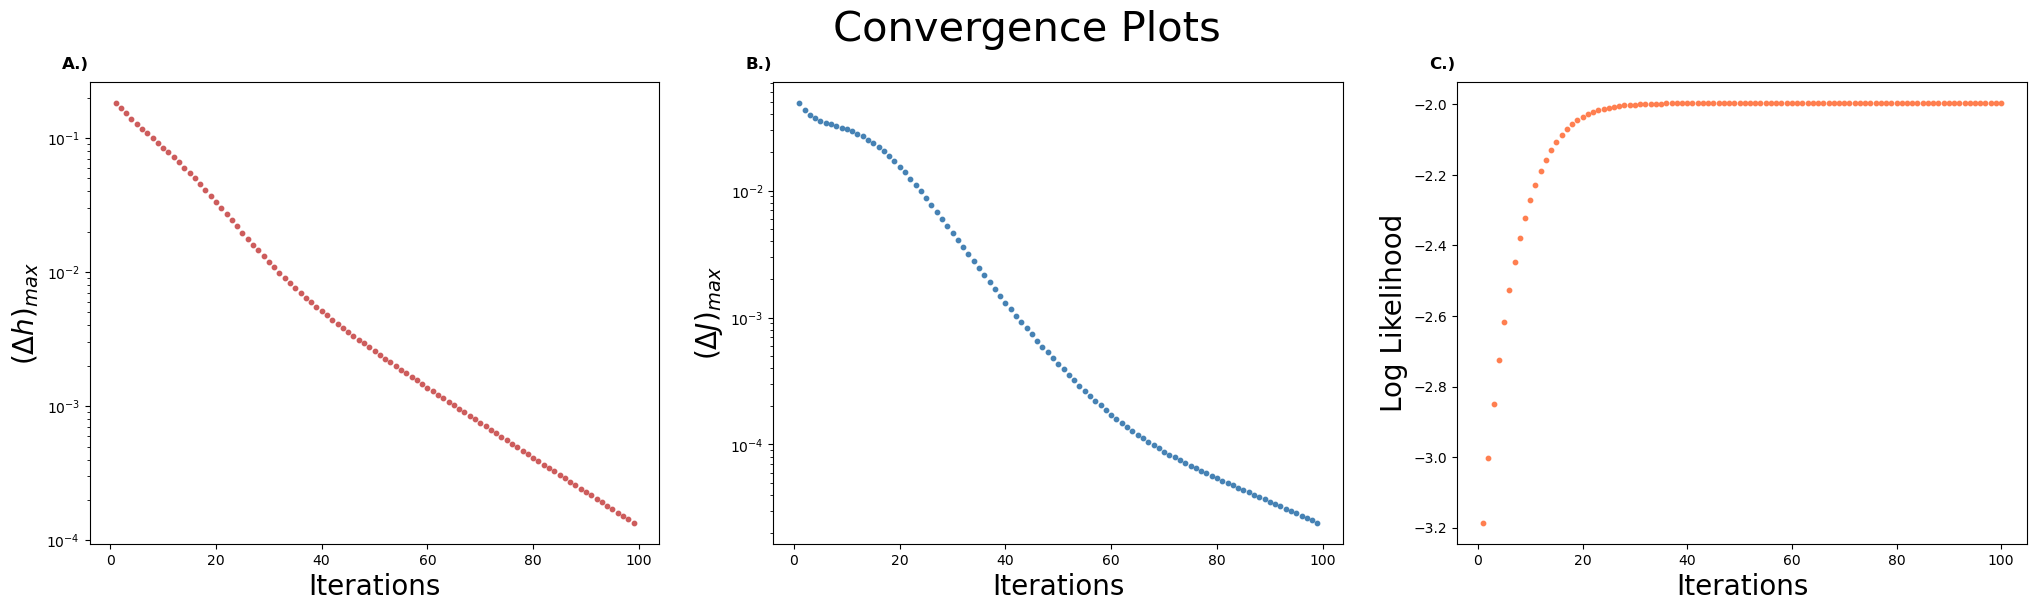

In [26]:
# Generate some random data
N = 3
configs = all_possible_configs(N)
p  = np.random.rand(2**N)
p /= np.sum(p)  # normalize to make it a valid probability distribution

# Run the Boltzmann machine
J, h, J_values, h_values, log_likelihood_values = classical_boltzmann_machine(p, N, configs, maxiter=100, learning_rate=0.1)

# Plot the convergence
plot_convergence(J_values, h_values, log_likelihood_values)

**Now we check if the Boltzmann machine can accurately retrieve the parameters from a predefined distribution. We generate a known set of parameters and then inspect if the Boltzmann machine can successfully recover these parameters. Please remember that the diagonal of J should be devoid of any entries, such that detailed balance is adhered to.**

In [27]:
def test_boltzmann_machine():
    # Define the known parameters
    N = 3
    known_J = np.array([[0, 1, -1], [1, 0, 1], [-1, 1, 0]], dtype=np.float64)
    known_h = np.array([1, -1, 1], dtype=np.float64)

    # Generate the known Boltzmann distribution
    configs = all_possible_configs(N)
    p = np.zeros(2**N)
    for i, config in enumerate(configs):
        config_float = config.astype(np.float64)  # convert config to float
        energy = calcEnergy(config_float, known_J, known_h)  # calculate energy
        p[i] = np.exp(-energy)  # calculate probability
    p /= np.sum(p)  # normalize

    # Run the Boltzmann machine
    J, h, _, _, _ = classical_boltzmann_machine(p, N, configs, maxiter=2**16, learning_rate=0.1)

    # Check that the recovered parameters are close to the known parameters
    assert np.allclose(J, known_J, atol=0.1), "Recovered J does not match known J"
    assert np.allclose(h, known_h, atol=0.1), "Recovered h does not match known h"

test_boltzmann_machine()
print("Test passed!")


Test passed!


**Check if the BM still works if we first generate a transition matrix with the parameters and then infer J and h:**

In [28]:
def test_params_to_W_to_BM():
    # Define the known parameters
    N = 3
    known_w = np.array([[4,6,8],
                        [6,5,6],
                        [8,6,8]],   dtype = np.float64)
    known_J = np.array([[0, 1, -1], 
                        [1, 0, 1], 
                        [-1, 1, 0]],dtype = np.float64)
    known_h = np.array([1, -1, 1],  dtype = np.float64)

    # generate the transition matrix
    W = compute_transition_matrix(known_w, known_h, known_J)

    # infer the equilibrium distribution p from W
    p = steady_state(W)
    
    # run the Boltzmann machine
    configs = all_possible_configs(N)
    J, h, _, _, _ = classical_boltzmann_machine(p, N, configs, maxiter=2**16, learning_rate=0.1)

    # Check that the recovered parameters are close to the known parameters
    assert np.allclose(J, known_J, atol=0.1), "Recovered J does not match known J"
    assert np.allclose(h, known_h, atol=0.1), "Recovered h does not match known h"

test_params_to_W_to_BM()
print("Test passed!")


Test passed!


Once we've obtained J and h, we can find the parameters w by rewriting the formula for the flipping probabilities:

 $$w_{ii}=\exp \left[-W^{emp}_{i i}-s_i\left(h_i+\sum_{i \neq j} J_{i j} s_j\right)\right]$$

$$w_{ij}(s) = \exp \left(-W^{emp}_{ij}+J_{ij} s_is_j - s_i \left[\sum_{i} J_{ik} s_k + h_i \right] - s_j \left[ \sum_{i'} J_{jk'} s_{k'} + h_j \right] \right)$$

where $W^{emp}$ are the empirically found transition probabilities.

In [29]:
def compute_w(W: np.ndarray, J: np.ndarray, h: np.ndarray) -> np.ndarray:
    """Computes the parameters w from the flip probabilities, J, h, and the spin states."""
    # Initialize w with zeros
    N = len(h)
    w = np.zeros((N, N))
    from_idx = 0 # arbitarly choose first row of W
    s = index_to_spin_state(from_idx, N)

    # sum over row entries of W, to find all possible w
    for to_idx in range(1,2**N,1):
        # calculate w_ii
        flipped_indices = bits_flipped_indices(from_idx, to_idx, N)
        
        if len(flipped_indices) == 0:  # no flip
            pass

        elif len(flipped_indices) == 1:  # single flip, compute wii
            i = flipped_indices[0]
            sum_Js = np.sum(J[i, :] * s)
            w[i, i] = -np.log(W[from_idx,to_idx] + 1e-10) - s[i] * (h[i] + sum_Js)

        elif len(flipped_indices) == 2:  # double flip, compute wij
            j, i = flipped_indices
            sum_Js_i = np.sum(J[i, :] * s) - J[i, j] * s[j]
            sum_Js_j = np.sum(J[j, :] * s) - J[i, j] * s[i]
            w[i, j] = -np.log(W[from_idx,to_idx]+ 1e-10) + J[i, j] * s[i] * s[j] - s[i] * (sum_Js_i + h[i]) - s[j] * (sum_Js_j + h[j])
            w[j, i] = w[i, j]  # w is symmetric

    return w

def infer_parameters(W: np.ndarray, maxiter: int = 2**20, learning_rate: float = 0.1, tolerance = 1e-10, plot = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Infers the parameters w, h, J from a given transition matrix."""
    N = int(np.log2(W.shape[0]))

    # infer the equilibrium distribution p from W
    p = steady_state(W)

    # run the Boltzmann machine
    configs = all_possible_configs(N)
    J, h, J_values, h_values, log_likelihood_values = classical_boltzmann_machine(p, N, configs, maxiter, learning_rate, tolerance )

    w = compute_w(W, J, h)

    if plot == True:
        plot_convergence(J_values, h_values, log_likelihood_values, title = 'BM Convergence')

    return w, J, h

**Check if we can fully recover the parameters w, h and J from a oracle transition matrix $W$:**

In [30]:
def test_infer_parameters():
    # Define the known parameters
    known_w = np.array([[4,6,8],
                        [6,5,6],
                        [8,6,8]],   dtype = np.float64)
    known_J = np.array([[0, 1, -1], 
                        [1, 0, 1], 
                        [-1, 1, 0]],dtype = np.float64)
    known_h = np.array([1, -1, 1],  dtype = np.float64)

    check_parameters(known_w, known_J ,known_h)

    # generate the transition matrix
    W = compute_transition_matrix(known_w, known_h, known_J)

    # Infer the parameters from the transition matrix
    w, J, h = infer_parameters(W)

    # Check that the inferred parameters are close to the known parameters
    assert np.allclose(w, known_w, atol=0.1), "Inferred w does not match known w"
    assert np.allclose(h, known_h, atol=0.1), "Inferred h does not match known h"
    assert np.allclose(J, known_J, atol=0.1), "Inferred J does not match known J"

test_infer_parameters()
print("Test passed!")

Test passed!


## **Obtaining a valid density matrix**

We want to make a similar mapping between transition probabilities and Hamiltonian parameters in the quantum domain. There are a two key differences in the quantum formalism:
1. The binary spins $s_i$ of the Hamiltonian are replaced by Pauli spin 1/2 operators $\sigma_i^k$
2. The transition matrix $W$ is replaced by a density matrix $\rho$ 

Let's implement both of these steps one at a time:

### 1. Defining the quantum Hamiltonian

The quantum Hamiltonian is defined as:

$H = \sum_{i} \sum_{j}\sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_i^k \otimes \sigma_j^{k'} + \sum_{i}\sum_{k} h^k_i \sigma_{i}^k$

where $w_{ij}^{kk'}$ is the coupling strength, $h_i$ are the local fields, and $\sigma_i^k$ are the Pauli operators. For the Pauli matrices, indexes $k=1,2,3$ correspond to $x,y,z$, index $k=0$ to the identity. We will implement both a function that generates the tensor product terms of the Pauli spin operators and a mechanism to associate a weight to each interaction term. 

In [31]:
# define the Pauli matrices globally
PAULI_I = np.array([[1, 0], [0, 1]],    dtype=np.complex128)
PAULI_X = np.array([[0, 1], [1, 0]],    dtype=np.complex128)
PAULI_Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
PAULI_Z = np.array([[1, 0], [0, -1]],   dtype=np.complex128)

# create an array of Pauli matrices and their labels
PAULI_MATRICES = np.array([PAULI_I, PAULI_X, PAULI_Y, PAULI_Z], dtype=np.complex128)
PAULI_LABELS = ['I', 'X', 'Y', 'Z']

def tensor_product(matrices: List[np.ndarray]) -> np.ndarray:
    """Compute the tensor product of a list of matrices."""
    result = matrices[0]
    # iterate over each matrix in the list starting from the second one
    for matrix in matrices[1:]:
        result = kron(result, matrix)
    return result
 
def generate_interaction_matrices(num_qubits: int) -> Tuple[np.ndarray, np.ndarray, Dict[Tuple[str, ...], Optional[float]]]:
    """Constructs the tensor product of Pauli matrices for each qubit pair."""
    num_combinations = 4 ** num_qubits # total number of combinations of Pauli matrices for num_qubits
    interaction_matrices = np.empty((num_combinations, 2 ** num_qubits, 2 ** num_qubits), dtype=np.complex128) 
    interaction_labels = np.empty((num_combinations, num_qubits), dtype=object)

    # initialize an empty dictionary to store the weights associated with each interaction matrix
    interaction_weights = {}

    # enumerate over all possible combinations of Pauli matrices for num_qubits
    for idx, matrix_indices in enumerate(product(range(4), repeat=num_qubits)):
        # select the corresponding Pauli matrices for the current combination
        matrices = PAULI_MATRICES[list(matrix_indices)]
        # compute the tensor product of the selected matrices
        interaction_matrix = tensor_product(matrices)

        # store the computed tensor product matrix and its corresponding labe
        interaction_matrices[idx] = interaction_matrix
        label_tuple = tuple(PAULI_LABELS[i] for i in matrix_indices)
        interaction_labels[idx] = label_tuple

        # initialize the weight associated with this interaction matrix
        # by default, it is set to None. You can change it later.
        interaction_weights[label_tuple] = None

    return interaction_matrices, interaction_labels, interaction_weights

```interaction_matrices``` is an array that holds the tensor product of Pauli matrices for each possible combination of qubits. It is ordered lexicographically. For a 3-qubit system the first entries look like this:

In [32]:
def print_matrix(matrix):
    for row in matrix:
        print('[', end='')
        for elem in row:
            real = elem.real
            imag = elem.imag
            if abs(real) < 1e-10 and abs(imag) < 1e-10:
                print("0", end=' ')
            elif abs(real) < 1e-10:
                print(f"{imag:.0f}j", end=' ')
            elif abs(imag) < 1e-10:
                print(f"{real:.0f}", end=' ')
            else:
                print(f"{real:.0f}+{imag:.2f}j", end=' ')
        print(']')
    print()
    

interactions, interaction_labels, interaction_weights = generate_interaction_matrices(3)

for i, label in enumerate(interaction_labels[:10]):
    print(label)
    # print_matrix(interactions[i])  #uncomment to see the associated matrix with each label

['I' 'I' 'I']
['I' 'I' 'X']
['I' 'I' 'Y']
['I' 'I' 'Z']
['I' 'X' 'I']
['I' 'X' 'X']
['I' 'X' 'Y']
['I' 'X' 'Z']
['I' 'Y' 'I']
['I' 'Y' 'X']


This lexiographic ordering is not very intuitive to index with weights. Because the amount of interaction matrices scales with $4^N$, it is non-trivial to index the weights, despite what kind of ordering we use. We can circumvent this problem by using a dictionary structure for the weights. We can then set the weights using the the interaction labels as follows:

In [33]:
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(3)

interaction_weights[('I', 'I', 'I')] = .1
interaction_weights[('I', 'I', 'X')] = .2
interaction_weights[('I', 'I', 'Y')] = .3
interaction_weights[('I', 'I', 'Z')] = .4
interaction_weights[('I', 'X', 'I')] = .5
interaction_weights[('I', 'X', 'X')] = .6
interaction_weights[('I', 'X', 'Z')] = .7
#interactions that are not defined, are automatically set to 0

Let's test if this structure works as intended. We print the weight and interaction matrix associated with $\sigma_{23}^{xy}$ and $\sigma_{123}^{zxy}$:

In [34]:
def test_interaction(label_tuple, interaction_matrices, interaction_labels, interaction_weights):
    """
    Given an interaction label, prints the associated interaction matrix and the associated weight.
    """
    # find the index of the label tuple in interaction_labels
    idx = np.where(np.all(interaction_labels == label_tuple, axis=1))[0][0]

    # fetch the corresponding interaction matrix
    interaction_matrix = interaction_matrices[idx]

    # fetch the corresponding weight
    weight = interaction_weights.get(label_tuple, None)

    print("Interaction Matrix for {}: \n".format(label_tuple))
    print_matrix(interaction_matrix)
    print("Associated weight: ", weight)

test_interaction(('I', 'X', 'Y'), interaction_matrices, interaction_labels, interaction_weights)
test_interaction(('Z', 'X', 'Y'), interaction_matrices, interaction_labels, interaction_weights)

Interaction Matrix for ('I', 'X', 'Y'): 

[0 0 0 -1j 0 0 0 0 ]
[0 0 1j 0 0 0 0 0 ]
[0 -1j 0 0 0 0 0 0 ]
[1j 0 0 0 0 0 0 0 ]
[0 0 0 0 0 0 0 -1j ]
[0 0 0 0 0 0 1j 0 ]
[0 0 0 0 0 -1j 0 0 ]
[0 0 0 0 1j 0 0 0 ]

Associated weight:  None
Interaction Matrix for ('Z', 'X', 'Y'): 

[0 0 0 -1j 0 0 0 0 ]
[0 0 1j 0 0 0 0 0 ]
[0 -1j 0 0 0 0 0 0 ]
[1j 0 0 0 0 0 0 0 ]
[0 0 0 0 0 0 0 1j ]
[0 0 0 0 0 0 -1j 0 ]
[0 0 0 0 0 1j 0 0 ]
[0 0 0 0 -1j 0 0 0 ]

Associated weight:  None


If we want our code to be compatible with numba NJIT compilation, we can't use dictionary formatting for our weights. However, we want to maintain the dictionary structure because it makes it significantly easier to associate a weight with each interaction matrix than using array indexing (which is varying for different amount of qubits). We thus need a way to convert a weights dictionary to 1D numpy array and vice versa:

In [35]:
def weights_dict_to_array(interaction_labels: np.ndarray, interaction_weights: Dict[Tuple[str, ...], Optional[float]]) -> np.ndarray:
    """
    Converts the interaction_weights dictionary to a numpy array based on the order of interaction_labels.
    """
    weights_array = np.array([interaction_weights[tuple(label)] if interaction_weights[tuple(label)] is not None else 0 for label in interaction_labels])
    return weights_array

def weights_array_to_dict(interaction_labels: np.ndarray, weights_array: np.ndarray) -> Dict[Tuple[str, ...], float]:
    """
    Converts a numpy array to an interaction_weights dictionary based on the order of interaction_labels.
    """
    interaction_weights = {tuple(label): weights_array[i] for i, label in enumerate(interaction_labels)}
    return interaction_weights

def generate_random_parameter_matrix(random_seed: int, num_qubits: int, interaction_labels: np.ndarray) -> np.ndarray:
    """
    Generates a random parameter array for the random seed value random_seed.
    Interactions containing more than 2-body interactions are set to zero.
    """
    np.random.seed(random_seed)  # set the random seed value
    num_params = 4**num_qubits   # calculate the number of parameters for the weight matrix
    w_array = np.random.rand(num_params)  # generate a random parameter array of size num_params

    # iterate over the interaction labels
    for i, label_tuple in enumerate(interaction_labels):
        # count the number of 'I' in the current label tuple
        num_I = np.count_nonzero(label_tuple == 'I')
        # if there are more than 2 'I', set the corresponding weight to 0
        if num_I < num_qubits - 2:
            w_array[i] = 0

    w_array[0] = 0 # -log(Z) = 0
    return w_array

**Let's test if these functions work as intended. We generate a random weight matrix with only up to 2-body interactions allowed and translate it to a dictionary structure and back**

In [36]:
# generate random weights array
random_seed = 666
num_qubits = 2
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)
w_random = generate_random_parameter_matrix(random_seed, num_qubits, interaction_labels)
print("Initial weights array: \n", w_random)

# numpy array to weights dictionary
interaction_weights = weights_array_to_dict(interaction_labels, w_random)
print("Weights dictionary:")
for interaction_label, interaction_weight in interaction_weights.items():
    print(interaction_label, format(interaction_weight, ".2f"))

# weights dictionary to numpy array
weights_array = weights_dict_to_array(interaction_labels, interaction_weights) 
print("Recovered weights array: \n ", weights_array)

Initial weights array: 
 [0.   0.84 0.68 0.73 0.95 0.01 0.41 0.05 0.1  0.51 0.2  0.74 0.19 0.7
 0.29 0.77]
Weights dictionary:
('I', 'I') 0.00
('I', 'X') 0.84
('I', 'Y') 0.68
('I', 'Z') 0.73
('X', 'I') 0.95
('X', 'X') 0.01
('X', 'Y') 0.41
('X', 'Z') 0.05
('Y', 'I') 0.10
('Y', 'X') 0.51
('Y', 'Y') 0.20
('Y', 'Z') 0.74
('Z', 'I') 0.19
('Z', 'X') 0.70
('Z', 'Y') 0.29
('Z', 'Z') 0.77
Recovered weights array: 
  [0.   0.84 0.68 0.73 0.95 0.01 0.41 0.05 0.1  0.51 0.2  0.74 0.19 0.7
 0.29 0.77]


Finally, it will be useful to have a function that calculates the full Hamiltonian matrix by combining all these functions:

In [37]:
@njit
def hamiltonian_n_qubits(interaction_weights: np.ndarray, interaction_matrices: np.ndarray) -> np.ndarray:
    """
    Calculates the Hamiltonian matrix of an n-qubit system
    """
    num_qubits = int(np.log2(interaction_matrices.shape[1]))
    H = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
    for i in range(len(interaction_weights)):
        H += interaction_weights[i] * interaction_matrices[i]

    return H

### 2.) Generating the density matrix

We can generate a density matrix as follows:
$$ \rho = \frac{e^{\hat{H}}}{Z} $$

Note that this involves taking the exponential of a _matrix_. Matrix exponentials (or logarithms) can be done using Hamiltonian eigendecomposition:
$$ \hat{H} \rarr E, \ket{E} $$
with $E$ and  $\ket{E}$  the eigenvalues and eigenvectors of $\hat{H}$, respectively. 
$$ \hat{H} = \sum_E E \ \ket{E} \bra{E} $$
using that 
$$f(\hat{H}) = \sum_E f(E) \ket{E} \bra{E} $$
we can compute the density matrix using
$$ \rho = \sum_E p_E \ket{E} \bra{E}$$

With  and $p_E = \frac{e^E}{Z}$ the eigenvalues. Let's implement this process in a function:

In [38]:
@njit
def expmat(A: np.ndarray) -> np.ndarray:
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A: np.ndarray) -> np.ndarray:
    """
    Computes the natural logarithm of a given matrix `A`. Same structure as expmat.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.log(evals[i]) * projector
    return res

Having this, we only have to calculate $ \rho = \frac{e^{\hat{H}}}{Z} $:

In [39]:
@njit
def rho_model(interaction_weights: np.ndarray, interaction_matrices: np.ndarray) -> np.ndarray:
    """
    Computes the density matrix of an n-qubit system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H = hamiltonian_n_qubits(interaction_weights, interaction_matrices)  # get Hamiltonian matrix
    rho = expmat(H)                                                      # definition of rho

    Z = np.real(np.trace(rho))                                           # get Z
    rho /= Z                                                             # normalize such that Tr[rho] = 1
    # for errors in numerical precision
    rho += 1e-6 * np.eye(rho.shape[0])

    return rho 


### Testing the density matrix

In [40]:
def check_density_matrix(rho, check_negative = False):  
    """Checks if the trace of rho is equal to 1 and if its eigenvalues are positive-semidefinite. Optional check for negative rho entries"""

    eigenvalues, _ = np.linalg.eig(rho)
    # check if rho is positive semi-definite
    if not np.all(eigenvalues >= 1e-6):
        raise ValueError(f"Matrix rho is not positive semi-definite. rho:\n{np.linalg.eigh(rho)[0]} \n {rho}")
    
    # check if rho is Hermitian
    if not np.allclose(rho, rho.conj().T):
        raise ValueError(f"Matrix rho is not Hermitian. rho: \n{rho}")
    
    # check if trace of rho is equal to 1
    if not np.isclose(np.trace(rho), 1):
        raise ValueError(f"The trace of rho is not equal to 1. rho: {np.trace(rho)} \n {rho}")
    
    if check_negative:
        # check if rho has negative elements
        if not np.all(rho >= 0):
            raise ValueError(f"Matrix rho contains negative values: \n{rho}")

In [41]:
# generate a density matrix
num_qubits = 2
interaction_matrices,interaction_labels,_ = generate_interaction_matrices(num_qubits)

np.random.seed(6)
test_w_qm = np.random.randint(0, 10, (16))

rho = rho_model(test_w_qm, interaction_matrices)
check_density_matrix(rho)

### Checking for imaginary elements

Due to the nature of the conversion when rho gets turned in a real-valued W, we can only recover density matrices that strictly consists of real values. Since $\rho = e^{\hat{H}} \approx 1 + \hat{H} + \frac{\hat{H}^2}{2!} + \dots$, a sufficient condition for ensuring rho is real would be to set all possible Hamiltonian interactions containing an uneven amount of y-interactions to zero. Let's double check if this is true:

In [42]:
def density_matrix_has_imaginary(num_qubits: int, interaction_tuple: np.ndarray) -> bool:
    # generate the interaction matrices and labels
    interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)

    # set all weights to 0
    for label in interaction_weights:
        interaction_weights[label] = 0.0

    # Convert numpy array to python tuple
    interaction_tuple = tuple(interaction_tuple)

    # set the weight for the specified interaction
    if interaction_tuple in interaction_weights:
        interaction_weights[interaction_tuple] = 10

    # convert weights dict to array
    interaction_weights_array = np.array([interaction_weights[tuple(label)] for label in interaction_labels])

    # get the relevant density matrix
    rho = rho_model(interaction_weights_array, interaction_matrices)

    # return whether there are any imaginary components
    return np.any(np.imag(rho) != 0)

def check_all_interactions(num_qubits: int) -> List[Tuple[str, ...]]:
    # generate the interaction matrices and labels
    _, interaction_labels, _ = generate_interaction_matrices(num_qubits)

    # initialize a list to hold the interactions that give rise to imaginary components
    imaginary_interactions = []

    # iterate over all interaction labels
    for interaction_tuple in interaction_labels:
        interaction_tuple = tuple(interaction_tuple)  # convert numpy array to tuple
        # if the interaction gives rise to imaginary components, add it to the list
        if density_matrix_has_imaginary(num_qubits, interaction_tuple):
            imaginary_interactions.append(interaction_tuple)

    return imaginary_interactions


In [43]:
print("All interactions leading to imaginary terms in a 2-qubit Hamiltonian")
print(check_all_interactions(2))
print("All interactions leading to imaginary terms in a 3-qubit Hamiltonian")
print(check_all_interactions(3))

All interactions leading to imaginary terms in a 2-qubit Hamiltonian
[('I', 'Y'), ('X', 'Y'), ('Y', 'I'), ('Y', 'X'), ('Y', 'Z'), ('Z', 'Y')]
All interactions leading to imaginary terms in a 3-qubit Hamiltonian
[('I', 'I', 'Y'), ('I', 'X', 'Y'), ('I', 'Y', 'I'), ('I', 'Y', 'X'), ('I', 'Y', 'Z'), ('I', 'Z', 'Y'), ('X', 'I', 'Y'), ('X', 'X', 'Y'), ('X', 'Y', 'I'), ('X', 'Y', 'X'), ('X', 'Y', 'Z'), ('X', 'Z', 'Y'), ('Y', 'I', 'I'), ('Y', 'I', 'X'), ('Y', 'I', 'Z'), ('Y', 'X', 'I'), ('Y', 'X', 'X'), ('Y', 'X', 'Z'), ('Y', 'Y', 'Y'), ('Y', 'Z', 'I'), ('Y', 'Z', 'X'), ('Y', 'Z', 'Z'), ('Z', 'I', 'Y'), ('Z', 'X', 'Y'), ('Z', 'Y', 'I'), ('Z', 'Y', 'X'), ('Z', 'Y', 'Z'), ('Z', 'Z', 'Y')]


Using this information, we can simply build a function that sets all these terms to 0:

In [44]:
def set_odd_y_interactions_to_zero(interaction_labels, interaction_weights):
    # iterate over each label tuple
    for label_array in interaction_labels:
        # convert numpy array to tuple
        label_tuple = tuple(label_array)
        # count the number of 'Y' in the label tuple
        num_y = label_tuple.count('Y')

        # if the count is odd, set the corresponding weight to 0
        if num_y % 2 == 1:
            interaction_weights[label_tuple] = 0

    return interaction_weights

Let's test if it works:

In [45]:
#generate the weights using the dictionary
num_qubits = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

interaction_weights[('I', 'I')] =  0
interaction_weights[('I', 'X')] = .1   #hx1
interaction_weights[('I', 'Y')] = .1   #hy1
interaction_weights[('I', 'Z')] = .1   #hz1

interaction_weights[('X', 'I')] = .1   #hx2
interaction_weights[('Y', 'I')] = 5   #hy2
interaction_weights[('Z', 'I')] = .1   #hz2

interaction_weights[('X', 'X')] = 10.6  #Jxx
interaction_weights[('Y', 'Y')] = 5    #Jyy
interaction_weights[('Z', 'Z')] = 0.4   #Jzz

interaction_weights[('X', 'Y')] = .7   #Jxy
interaction_weights[('Y', 'X')] = .6   #Jyx

interaction_weights[('X', 'Z')] = .5   #Jxz
interaction_weights[('Z', 'X')] = .4   #Jzx

interaction_weights[('Y', 'Z')] = 700   #Jyz
interaction_weights[('Z', 'Y')] = .4   #Jzy

interaction_weights_old = interaction_weights.copy()
interaction_weights_new = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

print(f" Old interaction weights:\n {interaction_weights_old}")
print(f"New interaction weights: \n {interaction_weights_new}")

 Old interaction weights:
 {('I', 'I'): 0, ('I', 'X'): 0.1, ('I', 'Y'): 0.1, ('I', 'Z'): 0.1, ('X', 'I'): 0.1, ('X', 'X'): 10.6, ('X', 'Y'): 0.7, ('X', 'Z'): 0.5, ('Y', 'I'): 5, ('Y', 'X'): 0.6, ('Y', 'Y'): 5, ('Y', 'Z'): 700, ('Z', 'I'): 0.1, ('Z', 'X'): 0.4, ('Z', 'Y'): 0.4, ('Z', 'Z'): 0.4}
New interaction weights: 
 {('I', 'I'): 0, ('I', 'X'): 0.1, ('I', 'Y'): 0, ('I', 'Z'): 0.1, ('X', 'I'): 0.1, ('X', 'X'): 10.6, ('X', 'Y'): 0, ('X', 'Z'): 0.5, ('Y', 'I'): 0, ('Y', 'X'): 0, ('Y', 'Y'): 5, ('Y', 'Z'): 0, ('Z', 'I'): 0.1, ('Z', 'X'): 0.4, ('Z', 'Y'): 0, ('Z', 'Z'): 0.4}


### Checking for negative elements

The off-diagonal elements of the density matrix (often called coherences) can be complex and may take negative values as part of their real or imaginary parts. If any elements of rho are negative, it will give rise to negative elements in W, which is unphysical. We want to derive the conditions for which the components of rho become negative. Once again, since $\rho = e^{\hat{H}} \approx 1 + \hat{H} + \frac{\hat{H}^2}{2!} + \dots$, a sufficient condition, but probably not necessary condition for ensuring rho is positive valued would mean ensuring each off-diagonal component of $\hat{H}$ is positive. The conditions for this are found by looking which interaction matrices contain the same non-zero entries and checking when their sum is positive. For 2-body interactions we can derive the following rules:

1. $\sigma_{ij}^{xx} > \sigma_{ij}^{yy} \ \ \ \ \  \ \ \ \ \ \ \forall  i,j$
2. $\sigma_{i}^{x} > \sum_{j \neq i} \sigma_{ij}^{xy} \ \ \ \forall i,j$

Note that these rules are only valid for 2-body interactions. If we allow for example 4-body interactions, the XXXX terms would have to balance out the YYYY terms. Also note that the diagonal z-terms alwayays give rise to some negative element on the diagonal. We physically know that it still maps to positive values, so this further implies our condition is sufficient, but not necessary.

We can computationally check these relations using a function that finds the pairs of interaction matrices with the same non-zero entries. You can perform the check yourself for 2, 3 and 4 qubit systems.

In [46]:
def matrix_to_pattern(matrix: np.ndarray) -> str:
    """
    Converts a matrix to a binary pattern string.
    1 denotes a non-zero entry and 0 denotes a zero entry.
    """
    binary_pattern = np.where(np.abs(matrix) > 1e-10, 1, 0)
    pattern_string = ''.join(binary_pattern.flatten().astype(str))
    return pattern_string

def find_identical_interaction_patterns(interaction_matrices: np.ndarray, interaction_labels: np.ndarray, print_matrices: bool = False, max_interaction: int = 2) -> Dict[str, List[str]]:
    """
    Finds interaction matrices that have the same non-zero entries and exclude labels containing an odd amount of 'Y' terms.
    The function returns a dictionary where each key is a binary pattern and each value is a list of labels that have the same pattern.
    max_interaction parameter controls the maximum number of non-I interactions to include. The default is 2.
    """
    # initialize an empty dictionary to store the patterns
    pattern_dict = {}

    # iterate over the interaction matrices
    for i, matrix in enumerate(interaction_matrices):
        # convert the matrix to a binary pattern string
        pattern = matrix_to_pattern(matrix)
        
        # convert numpy array to tuple for the label
        label_tuple = tuple(interaction_labels[i])

        # Exclude labels containing an odd amount of 'Y' terms
        if label_tuple.count('Y') % 2 != 0:
            continue

        # Exclude labels containing more than max_interaction non-I interactions
        if label_tuple.count('I') < len(label_tuple) - max_interaction:
            continue

        # if the pattern already exists in the dictionary, append the label to the list of labels
        if pattern in pattern_dict:
            pattern_dict[pattern].append(label_tuple)
        # if the pattern does not exist in the dictionary, create a new entry
        else:
            pattern_dict[pattern] = [label_tuple]
    
    # find patterns that have more than one label associated with them
    identical_patterns = {pattern: labels for pattern, labels in pattern_dict.items() if len(labels) > 1}

    # print the matrices if requested
    if print_matrices:
        for pattern, labels in identical_patterns.items():
            print(f'Pattern: {pattern}')
            for label in labels:
                idx = np.where(np.all(interaction_labels == label, axis=1))[0][0]
                print(f'Label: {label}')
                print_matrix(interaction_matrices[idx])

    return identical_patterns

In [47]:
interactions, interaction_labels, interaction_weights = generate_interaction_matrices(2)

identical_patterns = find_identical_interaction_patterns(interactions, interaction_labels, print_matrices=True, max_interaction=2)

Pattern: 1000010000100001
Label: ('I', 'I')
[1 0 0 0 ]
[0 1 0 0 ]
[0 0 1 0 ]
[0 0 0 1 ]

Label: ('I', 'Z')
[1 0 0 0 ]
[0 -1 0 0 ]
[0 0 1 0 ]
[0 0 0 -1 ]

Label: ('Z', 'I')
[1 0 0 0 ]
[0 1 0 0 ]
[0 0 -1 0 ]
[0 0 0 -1 ]

Label: ('Z', 'Z')
[1 0 0 0 ]
[0 -1 0 0 ]
[0 0 -1 0 ]
[0 0 0 1 ]

Pattern: 0100100000010010
Label: ('I', 'X')
[0 1 0 0 ]
[1 0 0 0 ]
[0 0 0 1 ]
[0 0 1 0 ]

Label: ('Z', 'X')
[0 1 0 0 ]
[1 0 0 0 ]
[0 0 0 -1 ]
[0 0 -1 0 ]

Pattern: 0010000110000100
Label: ('X', 'I')
[0 0 1 0 ]
[0 0 0 1 ]
[1 0 0 0 ]
[0 1 0 0 ]

Label: ('X', 'Z')
[0 0 1 0 ]
[0 0 0 -1 ]
[1 0 0 0 ]
[0 -1 0 0 ]

Pattern: 0001001001001000
Label: ('X', 'X')
[0 0 0 1 ]
[0 0 1 0 ]
[0 1 0 0 ]
[1 0 0 0 ]

Label: ('Y', 'Y')
[0 0 0 -1 ]
[0 0 1 0 ]
[0 1 0 0 ]
[-1 0 0 0 ]



We now can write a function that checks if we're using valid QM parameters using the following rules:

1. $\sigma_{ij}^{xx} > \sigma_{ij}^{yy} \ \ \ \ \  \ \ \ \ \ \ \forall  i,j$
2. $\sigma_{i}^{x} > \sum_{j \neq i} \sigma_{ij}^{xy} \ \ \ \forall i,j$
3. No odd Y terms
4. $\sigma^z_i$ < |1|

In [48]:
# def check_qm_parameters():
#     ###TO BE WRITTEN IF THIS IS SUFFICIENT

#### Test if these conditions are sufficient:

In [49]:
#generate the weights using the dictionary
num_qubits = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I')] =  0

#hx1 > Jxz
interaction_weights[('I', 'X')] = .8   #hx1
interaction_weights[('X', 'Z')] = .5   #Jxz

#hx2 > Jzx
interaction_weights[('X', 'I')] = .6   #hx2
interaction_weights[('Z', 'X')] = .4   #Jzx

# Jxx > Jyy
interaction_weights[('X', 'X')] = .6   #Jxx
interaction_weights[('Y', 'Y')] = .2   #Jyy

# all Z-only terms < 1
interaction_weights[('I', 'Z')] = .1   #hz1
interaction_weights[('Z', 'I')] = .1   #hz2
interaction_weights[('Z', 'Z')] = .4   #Jzz

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

# get rho
w_qm = weights_dict_to_array(interaction_labels, interaction_weights)
rho = rho_model(w_qm,interaction_matrices)\

check_density_matrix(rho, check_negative = True)

## **Implementation of the Quantum Boltzmann Machine**

Now that we can properly generate the interaction matrices, associate a weight with them and obtain the density matrix. We can build the quantum boltzmann machine:

In [50]:
###QBM AUXILLARY FUNCTIONS
#----------------------------------------------------------------------------------------------
@njit
def observables(rho: np.ndarray, interaction_matrices: np.ndarray) -> np.ndarray:
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros(len(interaction_matrices), dtype=np.complex128)
    rho_contig = np.ascontiguousarray(rho)

    for i, interaction_matrix in enumerate(interaction_matrices):   
        interaction_matrix_contig = np.ascontiguousarray(interaction_matrix)
        obs[i] = np.real(np.trace(np.dot(rho_contig, interaction_matrix_contig)))
    return obs

@njit
def KL_divergence(eta: np.ndarray, rho: np.ndarray) -> float:
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

@njit
def QM_likelihood(eta: np.ndarray, rho: np.ndarray) -> float:
    """
    Calculates the quantum Likelihood of the distribution
    """
    return -np.real(np.trace(eta @ logmat(rho)))

Now build the actual QBM

In [51]:
@njit
def quantum_boltzmann_machine(
    interaction_matrices: np.ndarray, 
    learning_rate: float, 
    maxiter: int, 
    tolerance: float, 
    w_initial: np.ndarray, 
    eta: np.ndarray = np.array([math.nan]), 
    w_eta: np.ndarray = np.array([math.nan])
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, int]:
    
    """
    Train the Quantum Boltzmann Machine (QBM) to fit the target distribution eta.    
    """
    # compute target density matrix using ED if oracle w_eta is provided, otherwise use provided eta
    if np.isnan(eta).any():
        assert not np.isnan(w_eta).any(), "Either eta or w_eta must be provided"
        eta = rho_model(w_eta, interaction_matrices)

    obs_clamped = observables(eta, interaction_matrices)  # get clamped QM statistics

    w = w_initial.copy()  # get initial weights for free QM statistics
    rho = rho_model(w, interaction_matrices)  # generate the density matrix rho for the initial weights
    obs_model = observables(rho, interaction_matrices)  # get free QM statistics

    it = 0  # initialize gradient ascent loop
    diff = np.inf
    W_list, lk_list, kl_list = np.zeros(maxiter), np.zeros(maxiter), np.zeros(maxiter)  # initialize values to store

    consecutive_small_change = 0  # counter for consecutive iterations with small change in W_max
    prev_W_diff = 0.0  # previous value of W_max

    while diff > tolerance and it < maxiter and consecutive_small_change < 20:
        rho = rho_model(w, interaction_matrices)  # get free QM statistics
        obs_model = observables(rho, interaction_matrices)
        w_previous = w.copy()
        w += learning_rate * np.real(obs_clamped - obs_model)  # Update weights

        if np.isnan(w_eta).any():
            W_diff = np.max(np.abs(w - w_previous))
            W_list[it] = W_diff

        else:
            Wmax = np.max(np.abs(w-w_eta))
            W_list[it] = Wmax                  

        # check if W_max has a small change compared to the previous iteration
        if np.abs(W_diff - prev_W_diff) < 1e-10:
            consecutive_small_change += 1
        else:
            consecutive_small_change = 0  # reset counter if W_max changes significantly
        prev_W_diff = W_diff

        diff = np.max(np.abs(obs_model - obs_clamped))  # evaluate differences in clamped and model statistics

        lk_list[it] = QM_likelihood(eta, rho)
        kl_list[it] = KL_divergence(eta, rho)
        it += 1
    
    return w, lk_list, kl_list, W_list, it

In [52]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot(it, Wmax, kl, lk, title='Convergence Plots', size=10):
    fig = plt.figure(figsize=(25, 6));                           #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.scatter(its, Wmax[:it], s=size, marker='o', color="SlateBlue")
    ax1.set_xlabel("Iterations", fontsize=20)
    ax1.set_ylabel(r"$ (\Delta w)_{max}$", fontsize=20)
    ax1.set_yscale('log')
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
   

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.scatter(its, kl[:it], s=size, marker='o', color="ForestGreen")
    ax2.set_xlabel("Iterations", fontsize=20)
    ax2.set_ylabel("KL Divergence", fontsize=20)
    ax2.set_yscale('symlog')  #symlog for when the KL divergence goes to zero
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(its, lk[:it], s=size, marker='o', color="Coral")
    ax3.set_xlabel("Iterations", fontsize=20)
    ax3.set_ylabel("Log Likelihood", fontsize=20)
    ax3.set_yscale('log')
    # ax3.set_ylim([0.482015, 0.482030])
    ax3.text(0, 1.0, 'B.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

### Check for 3-qubit system

We can now check if the QBM is capable of recovering the QM parameters from a density matrix. We generate a target density matrix eta from a random oracle weight matrix. We then check if the QBM can recover this oracle weight matrix.

Oracle Weights: 
 [0.   0.05 0.94 0.69 0.58 0.14 0.95 0.34 0.62 0.45 0.24 0.03 0.15 0.81
 0.65 0.54 0.04 0.47 0.89 0.48 0.41 0.   0.   0.   0.4  0.   0.   0.
 0.63 0.   0.   0.   0.14 0.17 0.22 0.09 0.05 0.   0.   0.   0.61 0.
 0.   0.   0.64 0.   0.   0.   0.97 0.47 0.41 0.79 0.37 0.   0.   0.
 0.15 0.   0.   0.   0.06 0.   0.   0.  ]
QBM Recovered Weights: 
 [ 0.    0.07  0.89  0.6   0.41  0.31  0.57  0.12  0.23  0.7   0.59 -0.18
  0.23  0.72  0.43  0.2   0.44  0.32  0.59  0.76  0.27  0.    0.19  0.04
  0.59 -0.17 -0.06 -0.07  0.63 -0.13  0.08 -0.01  0.35  0.31  0.15  0.26
  0.24 -0.03 -0.08 -0.17  0.54 -0.11 -0.23 -0.16  0.5  -0.05  0.05  0.03
  0.76  0.16  0.29  0.67  0.94  0.01  0.16  0.05  0.41  0.03  0.02  0.12
  0.19 -0.01  0.14  0.16]


/Users/ringo/opt/anaconda3/envs/QBM/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  func(*args, **kwargs)


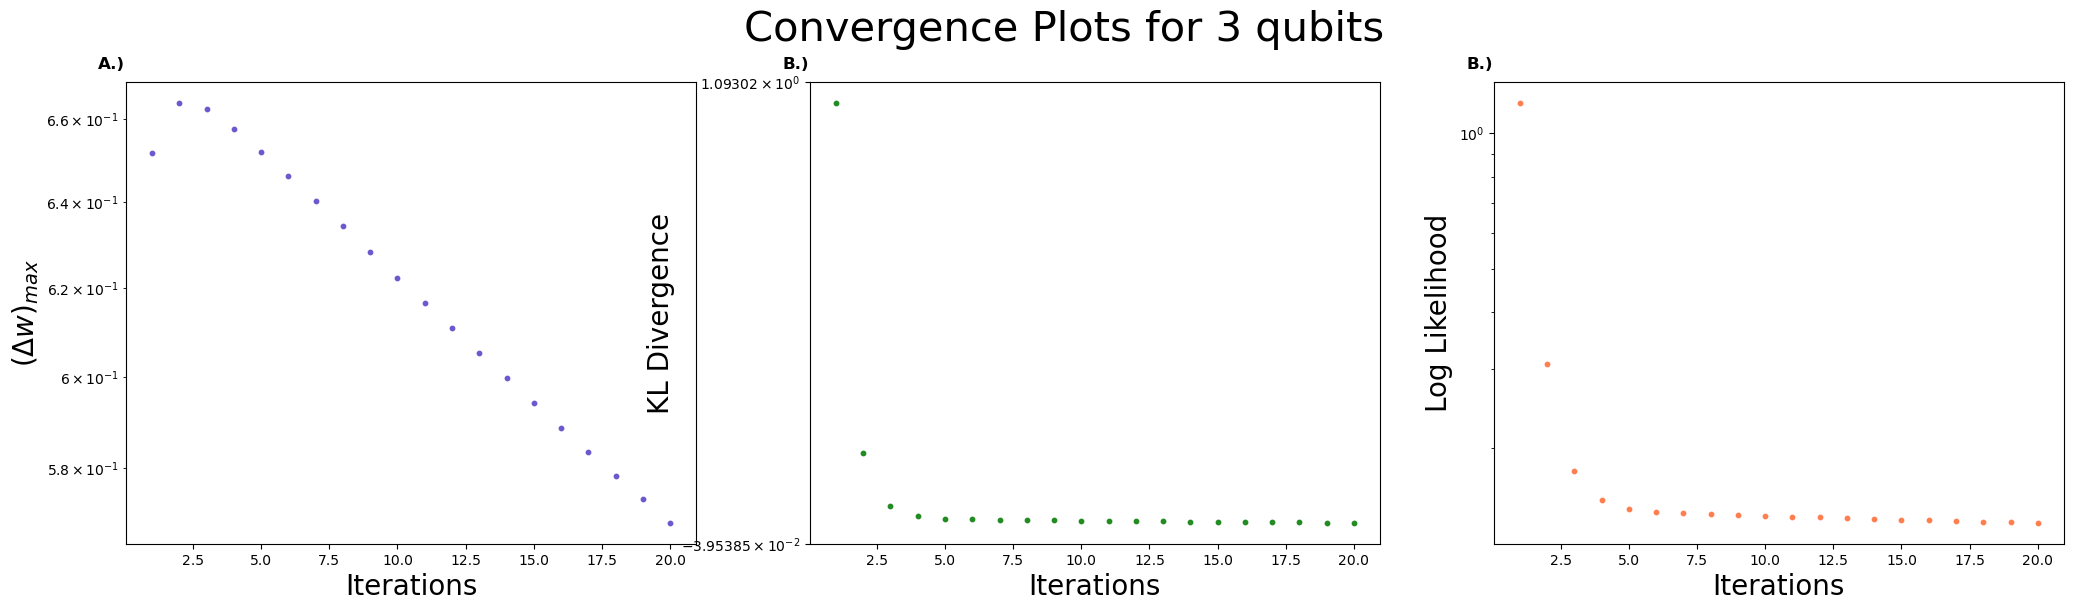

In [53]:
# 3-Qubit system parameters
num_qubits = 3
random_seed = 555

# generate interaction matrices and labels for up to 2-body interactions
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)

# randomly assign weights to each of the 16 possible interactions
w_oracle = generate_random_parameter_matrix(random_seed,num_qubits,interaction_labels)

# generate the target density matrix using the oracle interaction_weights
eta = rho_model(w_oracle, interaction_matrices)

# learning parameters
learning_rate = 0.6
maxiter = 2**18
tolerance = 1e-14

# set initial weights for QBM
w_initial= generate_random_parameter_matrix(random_seed + 1, num_qubits, interaction_labels)

# train the Quantum Boltzmann Machine to recover the oracle interaction weights
w_qbm, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate, maxiter, tolerance, w_initial, eta = eta, w_eta = w_oracle)

# print the recovered interaction weights and the oracle interaction weights for comparison
np.set_printoptions(precision=2, suppress=True)
print("Oracle Weights: \n", w_oracle)
print("QBM Recovered Weights: \n", w_qbm)

plot(it, Wdiff, kl, lk, title='Convergence Plots for 3 qubits', size=10)

- The left graph shows the largest difference between the entries of the oracle weight matrix and the QBM weight matrix vs the amount of iterations (if no oracle weight matrix is provided, it will show the change largest change in w_qbm compared to the previous iteration)  
- The middle graph shows the KL divergence vs the amount of iterations  
- The right graph shows the log likelihood

## **Bidirectional Conversion of Density Matrices and Transition Matrices**

Connecting the classical and quantum domain entails writing a function that converts a transition matrix in a density matrix and vice versa. The steady state distribution $p(s)$ of W can be obtained as the eigenvector of $W$ corresponding to the largest eigenvalue $\lambda_{max} =1$.
Given the classical data $p(s)$ and the dynamics $W(s|s')$ of a system, a symmetric density matrix can be obtained as follows:
\begin{equation} 
A \equiv \frac{1}{\sqrt{p(s)}} W(s|s') \sqrt{p(s')}
\end{equation}
By normalizing this matrix, the target distribution $\eta$ can be obtained:
\begin{equation}
\hat \eta = \frac{\hat A}{Tr{\hat A}}
\end{equation}
This process ensures that $\hat\eta$ is a semi-definite positive Hermitian operator. 

In [54]:
@njit
def transition_matrix_to_density_matrix(W: np.ndarray) -> np.ndarray:
    # calculate steady-state distribution p
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing

    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 

    # calculate the matrix A
    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))
    
    A = inv_sqrt_p_diag @ W.T @ sqrt_p_diag

    # symmetrize A to make it Hermitian
    A = 0.5 * (A + np.transpose(np.conjugate(A)))

    # add a scalar constant to all eigenvalues to make them non-negative (ensuring rho is positive semidefinite)
    min_eigval = np.min(np.real(np.linalg.eigvals(A)))
    if min_eigval < 0:
        A += (np.abs(min_eigval) + 1e-4) * np.eye(A.shape[0])

    #  normalize such that Tr[rho] = 1
    rho = A / np.real(np.trace(A))    
    rho = rho.astype(np.complex128) #make it complex    

    return rho


Using that the eigenvector of $\rho$ corresponding to the largest eigenvalue $\lambda_{max} =1$ is equal to $\sqrt{p(s)}$ we can invert the process:

In [55]:
@njit
def density_matrix_to_transition_matrix(rho: np.ndarray) -> np.ndarray:
    # obtain the steady-state distribution √p
    eigenvalues, eigenvectors = np.linalg.eigh(rho)
    sqrt_p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])

    # square the elements of the eigenvector and normalize to obtain the steady-state distribution
    p = sqrt_p**2
    p = p / np.sum(p)  # normalize
    epsilon = 1e-10  # small constant to prevent division by zero
    p = p + epsilon

    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))

    # calculate the matrix A
    A = np.real(rho)

    # compute the transition matrix W 
    W = sqrt_p_diag @ A @ inv_sqrt_p_diag
    W = W.T #switch back to row normalized by transposing

    # normalize each row to ensure the sum of each row equals 1
    W_row_sum = W.sum(axis=1)
    for i in range(W.shape[0]):
        W[i, :] /= W_row_sum[i]

    return W

### Testing the conversion

We check if the conversion is inversible and if the density matrix that is obtained from W is ergodic. This can be done in two different ways. The first one is a brute-force method which checks that for some power k of $\rho$, all entries of the density matrix are non-zero. The 2nd is more subtle. It checks if all single-spin flip transitions are allowed. If that's the case, then each state in phase space is reachable by the system.

In [56]:
### TEST FUNCTIONS
#----------------------------------------------------------------------
def check_inversiblity(W, rho):
    # test 1
    W_prime = density_matrix_to_transition_matrix(transition_matrix_to_density_matrix(W))
    np.testing.assert_array_almost_equal(W, W_prime, decimal=1, err_msg="Functions are not inverses. Failed in test 1.")

    # test 2
    rho_prime = transition_matrix_to_density_matrix(density_matrix_to_transition_matrix(rho))
    np.testing.assert_array_almost_equal(np.real(rho), np.real(rho_prime), decimal=2, err_msg="Functions are not inverses. Failed in test 2.")

def check_ergodicity(rho, K=10):
    """
    Check if the density matrix rho is ergodic by iteratively squaring
    the matrix up to K times and checking for non-zero entries.
    """
    for _ in range(K):
        if np.all(rho > 0):
            return

        # quadratic of the density matrix
        rho = rho @ rho

    # if after K iterations, there are still zero components, the matrix is not ergodic.
    assert False, "Matrix is not ergodic after {} iterations".format(K)

def check_single_flip_ergodicity(rho, W, n_spins):
    """
    Check if the components of the density matrix rho that correspond to 
    the transitions of the transition matrix W involving single spin flips are non-zero.
    """
    n_states = 2 ** n_spins

    for from_idx in range(n_states):
        for i in range(n_spins):
            # calculate the index of the state with the ith spin flipped
            to_idx = from_idx ^ (1 << i)

            # if the transition corresponds to a single spin flip and the component in rho is zero, raise an error
            assert not (W[from_idx, to_idx] > 0 and rho[from_idx, to_idx] == 0), "Single flip ergodicity failed at indices {} and {}".format(from_idx, to_idx)


#### Check inversibility for 2 (qu)bits:

In [57]:
# initialize the classical parameters
N = 2
w = np.array([[7,7],
              [7,7]], dtype=np.float64)
J = np.array([[0,4],
              [4,0]], dtype=np.float64)
h = np.array([0, 2],  dtype=np.float64)

check_parameters(w, J, h)

# generate a W and its associated rho
W = compute_transition_matrix(w, h, J)
rho_from_W = transition_matrix_to_density_matrix(W)

#perform checks on W and its associated W
test_transition_matrix(W)
check_density_matrix(rho_from_W, check_negative = True)
check_single_flip_ergodicity(rho_from_W, W, N)
check_ergodicity(rho_from_W)

#initialize the quantum paramters
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I')] =  0

#hx1 > Jxz
interaction_weights[('I', 'X')] = .8   #hx1
interaction_weights[('X', 'Z')] = .5   #Jxz

#hx2 > Jzx
interaction_weights[('X', 'I')] = .6   #hx2
interaction_weights[('Z', 'X')] = .4   #Jzx

# Jxx > Jyy
interaction_weights[('X', 'X')] = .8   #Jxx
interaction_weights[('Y', 'Y')] = .2   #Jyy

# all Z-only terms < 1
interaction_weights[('I', 'Z')] = .1   #hz1
interaction_weights[('Z', 'I')] = .1   #hz2
interaction_weights[('Z', 'Z')] = .4   #Jzz

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

#generate a rho and its associated W
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 
rho = rho_model(w_qm, interaction_matrices)

#density matrix to transition matrix
W_from_rho= density_matrix_to_transition_matrix(rho)

#perform checks on rho and its associated W
check_density_matrix(rho_from_W, check_negative = True)
test_transition_matrix(W_from_rho)
check_single_flip_ergodicity(rho, W_from_rho, N)
check_ergodicity(rho)

# check inversibility both ways
check_inversiblity(W, rho)

print("Test passed!")

/var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_31814/1472475405.py:20: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  W = sqrt_p_diag @ A @ inv_sqrt_p_diag
/Users/ringo/opt/anaconda3/envs/QBM/lib/python3.9/site-packages/numba/core/typing/npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


Test passed!


In [58]:
# initialize the classical parameters
N = 3
w = np.array([[8, 8 ,8],
              [8, 8, 8],
              [8, 8, 8]], dtype = np.float64)

J = np.array([[0, 3, 1],
              [3 ,0, 1],
              [1, 1, 0]], dtype = np.float64)

h = np.array([0, 1, 0],   dtype = np.float64)

check_parameters(w, J, h)

# generate a W and its associated rho
W = compute_transition_matrix(w, h, J)
rho_from_W = transition_matrix_to_density_matrix(W)

#perform checks on W and its associated W
test_transition_matrix(W)
check_density_matrix(rho_from_W, check_negative = True)
check_single_flip_ergodicity(rho_from_W, W, N)
check_ergodicity(rho_from_W, K=10)


#CHECL
num_qubits = 3
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I', 'I')] = 0    #log(Z)

#hxi > Jxzij + jxzik
interaction_weights[('X', 'I', 'I')] = .5   #hx1
interaction_weights[('X', 'Z', 'I')] = .1   #Jxz12
interaction_weights[('X', 'I', 'Z')] = .2   #Jxz13

interaction_weights[('I', 'X', 'I')] = .4   #hx2
interaction_weights[('I', 'X', 'Z')] = .1   #Jxz23
interaction_weights[('Z', 'X', 'I')] = .1   #Jzx12

interaction_weights[('I', 'I', 'X')] = .8   #hx3
interaction_weights[('I', 'Z', 'X')] = .2   #Jzx23
interaction_weights[('Z', 'I', 'X')] = .3   #Jzx13


# Jxx > Jyy
interaction_weights[('X', 'X', 'I')] = .6   #Jxx12
interaction_weights[('Y', 'Y', 'I')] = .4   #Jyy12

interaction_weights[('I', 'X', 'X')] = .7   #Jxx23
interaction_weights[('I', 'Y', 'Y')] = .4   #Jyy23

interaction_weights[('X', 'I', 'X')] = .8   #Jxx13
interaction_weights[('Y', 'I', 'Y')] = .4   #Jyy13


# all Z-only terms < 1
interaction_weights[('Z', 'I', 'I')] = .1   #hz1
interaction_weights[('I', 'Z', 'I')] = .1   #hz2
interaction_weights[('I', 'I', 'Z')] = .1   #hz3

interaction_weights[('Z', 'Z', 'I')] = .3   #Jzz12
interaction_weights[('Z', 'I', 'Z')] = .3   #Jzz13
interaction_weights[('I', 'Z', 'Z')] = .3   #Jzz23

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

#generate a rho and its associated W
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 
rho = rho_model(w_qm, interaction_matrices)

#density matrix to transition matrix
W_from_rho= density_matrix_to_transition_matrix(rho)

#perform checks on rho and its associated W
check_density_matrix(rho_from_W, check_negative = True)
test_transition_matrix(W_from_rho)
check_single_flip_ergodicity(rho, W_from_rho, N)


check_ergodicity(rho, K = 10)

# check inversibility both ways
check_inversiblity(W, rho)

print("Test passed!")

Test passed!


## **Quantum-Classical Mapping**

### Building the pipelines

We can build a pipeline for which we get input classical parameters and output qm parameters. We can also do the opposite, map qm parameters to classical ones. We call this the inverse route:

In [59]:
def forward_mapping(w: np.ndarray, J: np.ndarray, h: np.ndarray, learning_rate_qbm: float, maxiter_qbm: int, plot_convergence = False, perform_checks = True) -> np.ndarray:
    N = len(h)

    #get the transition matrix
    W = compute_transition_matrix(w,h,J)

    #convert it to a target density matrix
    eta = transition_matrix_to_density_matrix(W)

    # test if W and eta are valid
    if perform_checks:
        test_transition_matrix(W)
        check_density_matrix(eta)
        
    # learning parameters qbm
    tolerance = 1e-14
    random_seed = 444

    # set initial weights for QBM
    interaction_matrices, interaction_labels, _ = generate_interaction_matrices(N)
    w_initial= generate_random_parameter_matrix(random_seed + 1, N, interaction_labels)

    #infer its parameters using the QBM
    w_qm, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate_qbm, maxiter_qbm, tolerance, w_initial, eta=eta)
    
    #plot its convergence if needed
    if plot_convergence:
        plot(it, Wdiff, kl, lk, title='QBM Convergence', size=10)

    return w_qm


def inverse_mapping(w_qm: np.ndarray, learning_rate_bm: float, maxiter_bm: int, plot_convergence = False, perform_checks = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    N = int(np.log(w_qm.shape[0]) / np.log(4))

    #qm hamiltonian to density matrix
    interaction_matrices, _, _ = generate_interaction_matrices(N)
    rho = rho_model(w_qm, interaction_matrices)

    #density matrix to transition matrix
    W = density_matrix_to_transition_matrix(rho)

    # test if rho and W are valid
    if perform_checks:
        check_density_matrix(rho)
        test_transition_matrix(W)

    #infer the classical parameters using a classical boltzmann machine
    w, J, h = infer_parameters(W, maxiter_bm, learning_rate_bm, plot = plot_convergence)
    
    return w, J, h


### Testing the Pipelines

To check if the pipelines work properly, we can check if they are each others inverse. This will be done in the results section of this notebook.  

### Plotting the mappings

We'd like to be able to make plots to see how quantum parameters change when classical parameters are varied and vice versa. 

In [83]:
def qm_interaction_label_to_string(interaction_label: Tuple[str, ...]) -> str:
    """Convert an quantum interaction label tuple to a string (h, J or sigma)"""
    # Find indices of all non-I terms
    non_i_indices = [i for i, val in enumerate(interaction_label) if val != 'I']
    # Generate string based on number of non-I terms
    if len(non_i_indices) == 0:
        return f"$\log(Z)$"
    elif len(non_i_indices) == 1:
        return f"$h_{{{non_i_indices[0]+1}}}^{{{interaction_label[non_i_indices[0]]}}}$"
    elif len(non_i_indices) == 2:
        return f"$J_{{{non_i_indices[0]+1}{non_i_indices[1]+1}}}^{{{interaction_label[non_i_indices[0]]}{interaction_label[non_i_indices[1]]}}}$"
    else:
        i_terms = "".join([str(idx+1) for idx in non_i_indices])
        k_terms = "".join([interaction_label[idx] for idx in non_i_indices])
        return f"$\\sigma_{{{i_terms}}}^{{{k_terms}}}$"

def qm_string_to_interaction_label(label_string: str, N: int) -> Tuple[str, ...]:
    """Convert a quantum string label to an interaction label tuple."""
    # check if the string starts with 'l' (log Z)
    if label_string.startswith('l'):
        return tuple('I' for _ in range(N))

    # initialize a list of 'I's of length N
    interaction_label = ['I'] * N

    if label_string.startswith('$l'):
        return tuple(interaction_label)

    # check if the string starts with 'h' (bias)
    if label_string.startswith('$h'):
        # use regex to find the indices and axis in the label string
        m = re.match(r"\$h_\{(\d+)\}\^\{(\w)\}\$", label_string)
        index = int(m.group(1))
        axis = m.group(2)

        # replace the corresponding 'I' with axis
        interaction_label[index - 1] = axis

    # check if the string starts with 'J' (two-spin interaction)
    elif label_string.startswith('$J'):
        m = re.match(r"\$J_\{(\d+)(\d+)\}\^\{(\w)(\w)\}\$", label_string)
        indices = (int(m.group(1)), int(m.group(2)))
        axes = (m.group(3), m.group(4))

        # replace the corresponding 'I's with axes
        for i in range(2):
            interaction_label[indices[i] - 1] = axes[i]

    # otherwise, assume the string starts with '\sigma' (multi-spin interaction)
    else:
        m = re.match(r"\$\\sigma_\{(.+)\}\^\{(.+)\}\$", label_string)
        indices = tuple(map(int, m.group(1)))
        axes = tuple(m.group(2))

        # replace the corresponding 'I's with axes
        for i in range(len(indices)):
            interaction_label[indices[i] - 1] = axes[i]

    return tuple(interaction_label)



In [61]:
def analyze_forward_parameter_mapping(start: float, end: float, steps: int, param: str, index: Tuple[int], w: np.ndarray, J: np.ndarray, h: np.ndarray, learning_rate_qbm: float, maxiter_qbm: int, learning_rate_bm: float, maxiter_bm: int):
    """Plot change of QM parameters when a single classical parameter is varied."""
    # check that the input matrices are symmetric and J has a zero diagonal
    check_parameters(w, J, h)

    # create array of parameter values to test
    qm_param_values = np.linspace(start, end, steps)

    # create lists to hold quantum parameter values
    quantum_params = []

    N = len(h)
    _, interaction_labels, _ = generate_interaction_matrices(N)

    for idx, value in enumerate(qm_param_values):
        # update the corresponding parameter
        if param == 'w':
            w[index] = value
            w[index[::-1]] = value    # update symmetric element
        elif param == 'J':
            J[index] = value
            J[index[::-1]] = value    # update symmetric element
        elif param == 'h':
            h[index[0]] = value

        # check if new parameters are valid
        check_parameters(w, J, h)
        
        # forward mapping [only plot the last iteration]
        w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = False)

        # add to list
        quantum_params.append(w_qm)

    # check for inversibility of last iteration
    w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence= False, perform_checks = False)
    assert (np.allclose(w, w_recovered, atol = .1) and np.allclose(J, J_recovered, atol = .1) and np.allclose(h, h_recovered, atol = .1)), f"Mapping is not inversible."


    return quantum_params

def plot_forward_mapping(quantum_params, start, end, steps, param, index, N, qm_params_to_plot=None, threshold=0.01):
    qm_param_values = np.linspace(start, end, steps)
    _, interaction_labels, _ = generate_interaction_matrices(N)

    # Dictionary to map string labels to color
    label_color_map = {}

    _, interaction_labels, _ = generate_interaction_matrices(N)

    qm_str_labels = [qm_interaction_label_to_string(label) for label in interaction_labels]

    h_count = 0
    J_count = 0
    sigma_count = 0

    for qm_str_label in qm_str_labels:
        # Check if the string starts with 'h' (bias)
        if qm_str_label.startswith('h'):
            h_count += 1
            label_color_map[qm_str_label] = plt.cm.Dark1(h_count)

        # Check if the string starts with 'J' (two-spin interaction)
        elif qm_str_label.startswith('J'):
            J_count += 1
            label_color_map[qm_str_label] = plt.cm.Accent(J_count)

        # Otherwise, assume the string starts with '\sigma' (multi-spin interaction)
        else:
            sigma_count += 1
            label_color_map[qm_str_label] = plt.cm.Set3(sigma_count)

    # create plots for the changed parameters
    plt.figure(figsize=(10, 7))

    # find quantum parameters that have changed more than the threshold
    changed_params_booleans = np.abs(np.max(quantum_params, axis=0) - np.min(quantum_params, axis=0)) > threshold

    # get tuple labels to plot
    tuples_to_plot = np.array(interaction_labels)[changed_params_booleans]

    #convert tuple labels to strings
    qm_str_labels_to_plot = [qm_interaction_label_to_string(label) for label in tuples_to_plot]

    #sort them alphabetically and numerically
    sorted_qm_str_labels_to_plot = sorted(qm_str_labels_to_plot, key=lambda x: (x[0].isalpha(), x))

    print(sorted_qm_str_labels_to_plot)
    #convert them back to tuple labels
    sorted_tuples_to_plot = [qm_string_to_interaction_label(string, N) for string in sorted_qm_str_labels_to_plot]

    for i, label in enumerate(sorted_tuples_to_plot):
        qm_str_label = qm_interaction_label_to_string(label)
        classical_param_values = (np.array(quantum_params)[:, changed_params_booleans])[:, i]

        if qm_params_to_plot is None or qm_str_label in qm_params_to_plot:
            color = label_color_map[qm_str_label]
            plt.plot(qm_param_values, classical_param_values, label=qm_str_label, color=color)

    classical_param_index_str = "".join(str(idx + 1) for idx in index)  # convert to proper string for visualization
    plt.title(f'Variation of Quantum Parameters with Classical Parameter ${param}_{{ {classical_param_index_str} }}$')
    plt.xlabel(f'${param}_{{ {classical_param_index_str} }}$')
    plt.ylabel('Quantum Parameters')
    plt.legend()
    plt.show()



def analyze_inverse_parameter_mapping(start: float, end: float, steps: int, quantum_param_label: str, w_qm: np.ndarray, learning_rate_bm: float, maxiter_bm: int, classical_params_to_plot = None, threshold=0.01):
    """Plot change of Classical parameters when a single Quantum parameter is varied."""
    N  = int(np.log(w_qm.shape[0]) / np.log(4))
    
    # create array of quantum parameter values to test
    quantum_param_values = np.linspace(start, end, steps)

    # create lists to hold classical parameter values
    w_vals = []
    J_vals = []
    h_vals = []

    # find the index of quantum_param_label in interaction_labels
    _, _, interaction_weights = generate_interaction_matrices(N)
    param_index = list(interaction_weights.keys()).index((quantum_param_label))     

    for idx, value in enumerate(quantum_param_values):
        # update the quantum parameter
        w_qm[param_index] = value

        # perform the inverse mapping [only plot the last iteration]
        w, J, h = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = (idx == len(quantum_param_values)-1))

        # add to lists
        w_vals.append(w)
        J_vals.append(J)
        h_vals.append(h)

    # find classical parameters that have changed sufficiently
    changed_w = np.abs(np.max(np.diff(w_vals, axis=0), axis=0)) > threshold
    changed_J = np.abs(np.max(np.diff(J_vals, axis=0), axis=0)) > threshold
    changed_h = np.abs(np.max(np.diff(h_vals, axis=0), axis=0)) > threshold

    # flatten parameters
    w_vals = np.array(w_vals).reshape(steps,N**2)
    J_vals = np.array(J_vals).reshape(steps,N**2)
    h_vals = np.array(h_vals)
    changed_w = changed_w.flatten()
    changed_J = changed_J.flatten()
    changed_h = changed_h.flatten()

    # if specific parameters to plot are provided, use those
    if classical_params_to_plot is not None:
            print('this is not implemented yet!')

    # create plots for the changed parameters
    fig = plt.figure(figsize=(25, 6));     #  make plots
    qm_str_label = qm_interaction_label_to_string(quantum_param_label) #get string label of sweep qm parameter

    fig.suptitle(f'Variation of Classical Paramaters versus Quantum Parameter {qm_str_label}', fontsize=30, y = 1.1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

    ax1 = fig.add_subplot(1, 3, 1)
    for i, w_vals_changed in enumerate(w_vals[:,changed_w].T):
        original_index = np.unravel_index(i, (N, N))
        classical_param_index_str ="".join(str(idx + 1) for idx in original_index) #convert to proper string for visualization
        ax1.scatter(quantum_param_values, w_vals_changed, label= f'$w_{{ {classical_param_index_str} }}$', s = 15)
    ax1.set_xlabel(f'{qm_str_label}', fontsize=20)
    ax1.set_ylabel('$w$ parameters', fontsize=20)
    ax1.legend()
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    ax2 = fig.add_subplot(1, 3, 2)
    for i, J_vals_changed in enumerate(J_vals[:,changed_J].T):
        original_index = np.unravel_index(i, (N, N))
        classical_param_index_str ="".join(str(idx + 1) for idx in original_index) #convert to proper string for visualization
        ax2.scatter(quantum_param_values, J_vals_changed, label= f'$J_{{ {classical_param_index_str} }}$', s = 15)
    ax2.set_xlabel(f'{qm_str_label}', fontsize=20)
    ax2.set_ylabel('$J$ parameters', fontsize=20)
    ax2.legend()
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    ax3 = fig.add_subplot(1, 3, 3)
    plt.figure(figsize=(4,3))
    for i, h_vals_changed in enumerate(h_vals[:,changed_h].T):
        original_index = np.unravel_index(i, (N, N))
        classical_param_index_str ="".join(str(idx + 1) for idx in original_index) #convert to proper string for visualization
        ax3.scatter(quantum_param_values, h_vals_changed, label= f'$h_{{ {classical_param_index_str} }}$', s = 15)
    ax3.set_xlabel(f'{qm_str_label}', fontsize=20)
    ax3.set_ylabel('$h$ parameters', fontsize=20)
    ax3.legend()
    ax3.text(0, 1.0, 'B.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')


We can visualize classical dynamical effects equilibrium QM parameters might correspond to using the ```simulate_dynamics``` function.

### Test: Plotting the inversion error vs the size of the parameters

For too large parameter values it appears that the mapping is not reversible, is this a problem when only mapping forward?
The effect  of scale

Because of numerical precision, we need to scale down the parameters . If we don't, we can't recover the parameters properly. Mind that the parameters go into an exponential. They don't scale linearily. It might be necessary to scale down all parameters. We want to be able to check for what range of parameters we can accurately perform the forward mapping. Being able to invert it ensures the forward mapping is also done accurately.

If we scale down the classical parameters, it is possible to invert the mapping:

First we try for relatively large values of J, going to the max allowed values within the probabilities are still normalized properly:

In [ ]:
def perform_parameter_sweep(start, end, steps, param, index, w, J, h,
                            learning_rate_qbm, maxiter_qbm,
                            learning_rate_bm, maxiter_bm):
    """
    Perform a parameter sweep and plot the absolute inversion error.
    """

    qm_param_values = np.linspace(start, end, steps)
    inversion_error = []

    for idx, value in enumerate(qm_param_values):
        if param == 'w':
            w[index] = value
            w[index[::-1]] = value
        elif param == 'J':
            J[index] = value
            J[index[::-1]] = value
        elif param == 'h':
            h[index[0]] = value

        check_parameters(w, J, h)

        w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence=False)
        w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence=False)
        
        error = np.sum(np.abs(w - w_recovered)) + np.sum(np.abs(J - J_recovered)) + np.sum(np.abs(h - h_recovered))
        inversion_error.append(error)

    plt.figure(figsize=(10, 7))
    plt.plot(qm_param_values, inversion_error)
    classical_param_index_str = "".join(str(idx + 1) for idx in index)
    plt.title(f'Absolute Inversion error when varying ${param}_{{ {classical_param_index_str} }}$')
    plt.xlabel(f'${param}_{{ {classical_param_index_str} }}$')
    plt.ylabel('Sum of absolute error between initial and recovered parameters')
    plt.show()


As a test, we check when our mapping does not become inversible. We should not use those ranges.

In [ ]:
perform_parameter_sweep(start, end, steps, param, index, w, J, h,
                            learning_rate_qbm, maxiter_qbm,
                            learning_rate_bm, maxiter_bm)

In [ ]:
# initialize the classical parameters
w = np.array([[14, 14], 
              [14, 14]], dtype=np.float64)
J = np.array([[0, 1],
              [1, 0]],  dtype=np.float64)
h = np.array([1, -1],    dtype=np.float64)

# make sure w are large enough for normalized probabilities
check_parameters(w,J,h)

#intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**10

learning_rate_bm = .9
maxiter_bm = 2**20

#initialize sweep 
param = 'J'
index = (0,1)
steps = 30

# create array of parameter values to test. 
#THIS IS THE MAXIMUM SWEEPING RANGE ALLOWED
qm_param_values = np.linspace(-11.95, 11.95, steps)

# create lists to hold the error sizes
inversion_error = []

N = len(h)
_, interaction_labels, _ = generate_interaction_matrices(N)

for idx, value in enumerate(qm_param_values):
    # update the corresponding parameter
    if param == 'w':
        w[index] = value
        w[index[::-1]] = value    # update symmetric element
    elif param == 'J':
        J[index] = value
        J[index[::-1]] = value    # update symmetric element
    elif param == 'h':
        h[index[0]] = value

    # check if new parameters are valid
    check_parameters(w, J, h)
    
    # forward mapping 
    w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = False)

    # check for inversibility of last iteration
    w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence= False)
    
    #compute the absolute error
    error = np.sum(np.abs(w - w_recovered)) + np.sum(np.abs(J - J_recovered)) + np.sum(np.abs(h - h_recovered))

    # add to list
    inversion_error.append(error)

# create plots for the error
plt.figure(figsize=(10,7))

plt.plot(qm_param_values, inversion_error)

classical_param_index_str ="".join(str(idx + 1) for idx in index) #convert to proper string for visualization
plt.title(f'Absolute Inversion error when varying ${param}_{{ {classical_param_index_str} }}$')
plt.xlabel(f'${param}_{{ {classical_param_index_str} }}$')
plt.ylabel('Sum of absolute error between initial and recovered parameters')
plt.legend()
plt.show()

In [ ]:
# initialize the classical parameters
w = np.array([[14, 14], 
              [14, 14]], dtype=np.float64)
J = np.array([[0, 1],
              [1, 0]],  dtype=np.float64)
h = np.array([1, -1],    dtype=np.float64)

# make sure w are large enough for normalized probabilities
check_parameters(w,J,h)

#intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**10

learning_rate_bm = .9
maxiter_bm = 2**20

#initialize sweep 
param = 'J'
index = (0,1)
start = -11.95
end   = 11.95
steps = 30


perform_parameter_sweep(start, end, steps, param, index, w, J, h,
                            learning_rate_qbm, maxiter_qbm,
                            learning_rate_bm, maxiter_bm)

Then we try for relatively small values of w and J but still going to the max allowed values of J. Then we can see if the error has to do with numerical precision or with going to the edge of normalization:

In [ ]:
# initialize the classical parameters
w = np.array([[3,3], 
              [3,3]], dtype=np.float64)
J = np.array([[0, 2.21],
              [2.21, 0]],  dtype=np.float64)
h = np.array([.1, -.1],    dtype=np.float64)

# make sure w are large enough for normalized probabilities
check_parameters(w,J,h)

In [ ]:
# initialize the classical parameters
w = np.array([[3,3], 
              [3,3]], dtype=np.float64)
J = np.array([[0, .1],
              [.1, 0]],  dtype=np.float64)
h = np.array([.1, -.1],    dtype=np.float64)

# make sure w are large enough for normalized probabilities
check_parameters(w,J,h)

#intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**10

learning_rate_bm = .9
maxiter_bm = 2**20

#initialize sweep 
param = 'J'
index = (0,1)
steps = 50

# create array of parameter values to test
qm_param_values = np.linspace(-2.19, 2.19, steps)

# create lists to hold the error sizes
inversion_error = []

N = len(h)
_, interaction_labels, _ = generate_interaction_matrices(N)

for idx, value in enumerate(qm_param_values):
    # update the corresponding parameter
    if param == 'w':
        w[index] = value
        w[index[::-1]] = value    # update symmetric element
    elif param == 'J':
        J[index] = value
        J[index[::-1]] = value    # update symmetric element
    elif param == 'h':
        h[index[0]] = value

    # check if new parameters are valid
    check_parameters(w, J, h)
    
    # forward mapping 
    w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = False)

    # check for inversibility of last iteration
    w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence= False)
    
    #compute the absolute error
    error = np.sum(np.abs(w - w_recovered)) + np.sum(np.abs(J - J_recovered)) + np.sum(np.abs(h - h_recovered))

    # add to list
    inversion_error.append(error)

# create plots for the error
plt.figure(figsize=(10,7))

plt.plot(qm_param_values, inversion_error)

classical_param_index_str ="".join(str(idx + 1) for idx in index) #convert to proper string for visualization
plt.title(f'Absolute Inversion error when varying ${param}_{{ {classical_param_index_str} }}$')
plt.xlabel(f'${param}_{{ {classical_param_index_str} }}$')
plt.ylabel('Sum of absolute error between initial and recovered parameters')
plt.legend()
plt.show()

# **Results Quantum-Classical Mapping**

**We now got all tools available to analyze some results of the parameter mapping.**

THINGS TO CHECK:
- Try homogenous systems first [all parameters of a kind the same]
- Check biases <-> sigma z correspondence
- Make a way to systematically review the change in parameters. Plots of the change in parameters versus the change in an other.
- Interpret wyy, wxx terms.
- Parameters of a dynamics system map to a stationary thing?
- Check if KL goes to zero for larger systems and quantum hamiltonian with 2body interactions.
- Get same graphs as PPT dynamics
- Investigate non-zero 3 body interactions in QM Hamiltonian
- What quantum information do we lose when transfering it to a classical object?


## Forward Reversibility

### Reversibility for 2-qubits

Since for a 2-qubit system, the Hamiltonian is a complete model, we would expect that the mapping $w_{cl} \rarr w_{qm} \rarr w_{cl}$ works.

In [ ]:
# initialize the classical parameters
N = 2
w = np.array([[8,9],
              [9,8]], dtype=np.float64)
J = np.array([[0,4],
              [4,0]], dtype=np.float64)
h = np.array([0, 2],  dtype=np.float64)

# make sure w are large enough for normalized probabilities
check_parameters(w,J,h)

#intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .2
maxiter_qbm = 2**8

learning_rate_bm = .9
maxiter_bm = 2**20

# map forward and back
w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = True)
w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = True)

print('Difference in initial and recovered parameters:')
print(f'w: \n {np.abs(w - w_recovered)}')
print(f'J: \n {np.abs(J - J_recovered)}')
print(f'h: \n {np.abs(h - h_recovered)}')

And so it does. Interestingly, for the same learning rate, the QBM converges WAY faster,but can only converge up to 1e-6. BM can converge all the way till 1e-14.  The QBM takes about 50 iterations to converge to 1e-6 while the BM takes ....

### Reversibility for 3-qubits


Another open question is if we are be able to invert the forward mapping for a non-complete Hamiltonian (i.e. N > 2). Let's try for a 3-qubit system:

In [ ]:
# initialize the classical parameters
N = 3
w = np.array([[12   , 10.01, 12.01],
              [10.01, 12.01,  9.01],
              [12.01,  9.01, 12.01]] , dtype=np.float64)
J = np.array([[0,1,2],
              [1,0,1],
              [2,1,0]], dtype=np.float64)
h = np.array([1, 2, 3], dtype=np.float64)

check_parameters(w,J,h)


#intialize the optimal learning parameters for 3-qubits
learning_rate_qbm = .9
maxiter_qbm = 2**10

learning_rate_bm = .9
maxiter_bm = 2**20

# map forward and back
w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = True, perform_checks = True)
w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = True, perform_checks = False)

print('Difference in initial and recovered parameters:')
print(f'w: \n {np.abs(w - w_recovered)}')
print(f'J: \n {np.abs(J - J_recovered)}')
print(f'h: \n {np.abs(h - h_recovered)}')

- We can recover the parameters, pretty accurately, even though we don't use a complete Hamiltonian. Note that we do have to turn of the checking of valid W and rho because some values get slighly negative due inaccuracies.
- Don't quite understand what happens with the KL-divergence though. This effect seems to occur no matter how low a learning rate is chosen (e.g. for  $\alpha_{QBM} = 0.001$ this still happens).

### Reversibility for 4-qubits

In [ ]:
dont_run = 0  #skip this due to long computation time
if dont_run == 1: 

    # initialize the classical parameters
    N = 4
    w = np.array([[5.20,5.24,5.26,5.17],
                  [5.24,5.26,5.20,5.19],
                  [5.26,5.20,5.22,5.20],
                  [5.17,5.19,5.20,5.20]], dtype=np.float64)
    
    J = np.array([[0,.1,.2,.3],
                  [.1,0,.1,.3],
                  [.2,.1,0,.2],
                  [.3,.3,.2,0]],      dtype=np.float64)
    
    h = np.array([1, 2, 1, 2],        dtype=np.float64)

    check_parameters(w,J,h)

    #intialize the optimal learning parameters for 4-qubits
    learning_rate_qbm = .1
    maxiter_qbm = 2**11

    learning_rate_bm = .004
    maxiter_bm = 2**22

    # map forward and back
    w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = True, perform_checks = True)
    w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = True, perform_checks = False)

    print('Difference in initial and recovered parameters:')
    print(f'w: \n {np.abs(w - w_recovered)}')
    print(f'J: \n {np.abs(J - J_recovered)}')
    print(f'h: \n {np.abs(h - h_recovered)}')

## Forward Mapping

We have to make sure that for all values of the parameter sweep, we don't need to use min_w. Probably write another function for that sometime

### Results 2-qubits

#### Varying J in Homogenous system with biases and self-interactions

In [62]:
# initialize the classical parameters
N = 2
w = np.array([[3, 3], 
              [3, 3]],   dtype=np.float64)
J = np.array([[0, 1],
              [1, 0]],   dtype=np.float64)
h = np.array([.1, .1],   dtype=np.float64)

# define the classical parameter that will be varied
param = 'J'
index = (0, 1)

# define the range over which the classical parameter will be varied
start = -2.15
end = 2.15
steps = 100

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**22

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# plot_params = [ 'J^{XZ}_{14}', 'h^{Y}_{2}', ''sigma^{YXZ}_{123}] #should work somehthing like this

# specify the change threshold
threshold = 0.1

# call the function
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

plot_forward_mapping(quantum_params, start, end, steps, param, index, N, qm_params_to_plot, threshold)


['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$']


AttributeError: 'NoneType' object has no attribute 'group'

<Figure size 1000x700 with 0 Axes>

#### Varying J in Homogenous system with self-interactions but no biases

In [ ]:
# initialize the parameters
N = 2
w = np.array([[3, 3], 
              [3, 3]], dtype=np.float64)
J = np.array([[0, 1],
              [1, 0]],   dtype=np.float64)
h = np.array([.00000000000001, .00000000000001],    dtype=np.float64)

check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'J'
index = (0, 1)

# define the range over which the classical parameter will be varied
start = -2.15
end = 2.15
steps = 100

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**11

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# plot_params = [ 'J^{XZ}_{14}', 'h^{Y}_{2}', ''sigma^{YXZ}_{123}] #should work somehthing like this

# specify the change threshold
threshold = 0.1

# call the function
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

plot_forward_mapping(quantum_params, start, end, steps, param, index, N, qm_params_to_plot, threshold)


### Results 3-qubit

#### Varying J in Homogenous system with biases and self-interactions

In [ ]:
# initialize the parameters
N = 3
w = np.array([[3, 3 ,3],
              [3, 3, 3],
              [3, 3, 3]], dtype = np.float64)

J = np.array([[0, 0, 0],
              [0 ,0, 0],
              [0, 0, 0]], dtype = np.float64)

h = np.array([.1, .1, .1],   dtype = np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'J'
index = (0, 1)

# define the range over which the classical parameter will be varied
start = -.7
end = .7
steps = 30

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**11

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = ['$J_{12}^{ZZ}$', '$J_{12}^{YY}$'] 


# specify the change threshold
threshold = 0.00001

# call the function
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

plot_forward_mapping(quantum_params, start, end, steps, param, index, N, qm_params_to_plot, threshold)

Smaller biases

In [ ]:
# initialize the parameters
N = 3
w = np.array([[3, 3 ,3],
              [3, 3, 3],
              [3, 3, 3]], dtype = np.float64)

J = np.array([[0, 0, 0],
              [0 ,0, 0],
              [0, 0, 0]], dtype = np.float64)

h = np.array([.000001, .000001, .000001],   dtype = np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'J'
index = (1, 2)

# define the range over which the classical parameter will be varied
start = -.7
end = .7
steps = 30

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**11

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = ['$J_{12}^{ZZ}$', '$J_{12}^{YY}$'] 

# specify the change threshold
threshold = 0.00001

# call the function
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

plot_forward_mapping(quantum_params, start, end, steps, param, index, N, qm_params_to_plot, threshold)

AttributeError: 'NoneType' object has no attribute 'group'

### Same shit, larger biases

In [ ]:
# initialize the parameters
N = 3
w = np.array([[3, 3 ,3],
              [3, 3, 3],
              [3, 3, 3]], dtype = np.float64)

J = np.array([[0, 0, 0],
              [0 ,0, 0],
              [0, 0, 0]], dtype = np.float64)

h = np.array([.75, .75, .75],   dtype = np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'J'
index = (0, 1)

# define the range over which the classical parameter will be varied
start = 0
end = .70
steps = 30

learning_rate_qbm = .5
maxiter_qbm = 2**20

#only relevant for checking if the mapping is inversible
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = ['$J_{12}^{ZZ}$', '$J_{12}^{YY}$'] 

# specify the change threshold
threshold = 0.01

# call the function
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

plot_forward_mapping(quantum_params, start, end, steps, param, index, N, qm_params_to_plot, threshold)

### Results 4-qubit

Expect 30-40 min for convergence of QBM. Try agressive learning rates first

In [ ]:
dont_run = 1  #skip this due to long computation time
if dont_run == 0: 

    # initialize the classical parameters
    w = np.array([[4.,2.,4.,5.],
                [2.,4.,1.,3.],
                [4.,1.,2.,4.],
                [5.,3.,4.,5.]])
    J = np.array([[0,1,2,3],
                [1,0,1,3],
                [2,1,0,2],
                [3,3,2,0]])
    h = np.array([1, 2, 3, 4])

    check_parameters(w,J,h)

    # define the start, end and step size for the parameter change
    start = -10
    end = 10
    steps = 30

    # define the parameter and index you want to change
    param = 'J'
    index = (0, 1)

    # intialize the optimal learning parameters for 3-qubits
    learning_rate_qbm = .9
    maxiter_qbm = 2**15

    learning_rate_bm = .9
    maxiter_bm = 2**20

    # specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
    plot_params = None
    # plot_params = ['w_0_1', 'J_0_1', 'h_0']

    # specify the change threshold
    threshold = 0.01

    # call the function
    analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, plot_params, threshold)


## Inverse Mapping

In [ ]:
#plot the dynamics
N = 2
steps = 200
W = compute_transition_matrix(w, h, J)
trajectory = simulate_dynamics(W, steps, N)
plot_combined_dynamics(trajectory, N)

### Inverse mapping reversibility

- Check what happens when you use 3rd body interactions in the QM hamiltonian

#### When QM parameters map to a dynamics that does not satisfy detailed balance

In [ ]:
N = 2

#initialize the quantum paramters
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I')] =  0

#hx1 > Jxz
interaction_weights[('I', 'X')] = .8   #hx1
interaction_weights[('X', 'Z')] = .5   #Jxz

#hx2 > Jzx
interaction_weights[('X', 'I')] = .6   #hx2
interaction_weights[('Z', 'X')] = .4   #Jzx

# Jxx > Jyy
interaction_weights[('X', 'X')] = .8   #Jxx
interaction_weights[('Y', 'Y')] = .2   #Jyy

# all Z-only terms < 1
interaction_weights[('I', 'Z')] = .1   #hz1
interaction_weights[('Z', 'I')] = .1   #hz2
interaction_weights[('Z', 'Z')] = .4   #Jzz

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

#generate a rho and its associated W
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

rho = rho_model(w_qm,interaction_matrices)
check_density_matrix(rho)

W = density_matrix_to_transition_matrix(rho)
test_transition_matrix(W)
check_detailed_balance(W)

#infer the classical parameters using a classical boltzmann machine
w, J, h = infer_parameters(W, maxiter = 2**14, learning_rate = .2, plot = True)

W_return = compute_transition_matrix(w, h, J)

print(f'Initial qm parameters: {w_qm}')
print(f'Density matrix: \n {rho_model(w_qm,interaction_matrices)}')
print(f'Transition matrix: \n {W}')
print(f'Returned transition matrix \n {W_return}')

In [ ]:
W = np.array( [[0.49, 0.21, 0.22, 0.08],
               [0.46, 0.24, 0.23, 0.07],
               [0.46, 0.22, 0.24, 0.08],
               [0.44, 0.18, 0.21, 0.17]])

check_detailed_balance(W)

# W_sym = W + 

#check validity of W
check_detailed_balance(W)
test_transition_matrix(W)

w, J, h = infer_parameters(W)

print(w)
print(J)
print(h)

W_return = compute_transition_matrix(w, h, J)
print(W_return)
check_parameters(w,J,h)


In [ ]:
#intialize the learning parameters
learning_rate_qbm = .9
maxiter_qbm = 2**14

learning_rate_bm = .9
maxiter_bm = 2**18


w, J, h = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = True)

print('Rho maps to classical parameters:')
print(f' w: \n {w}')
print(f' J: \n {J}')
print(f' h: \n {h}')

w_qm_recovered = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = True)

print(f'Difference in initial and recovered parameters: \n {np.abs(w_qm - w_qm_recovered)}')

Splitting W into a symmetric and assymetric part. Maybe we can split into a symmetric part and assymetric part and individually see to which QM parameters these transition matrices map back. In the symmetric case, we can also map it forward to classical parameters.

#### check if symmetry of the xz zx terms leads to detailed balance


In [ ]:
#generate the weights using the dictionary
num_qubits = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I')] =  0

#hx1 > Jxz
interaction_weights[('I', 'X')] = .8   #hx1
interaction_weights[('X', 'Z')] = .5   #Jxz

#hx2 > Jzx
interaction_weights[('X', 'I')] = .6   #hx2
interaction_weights[('Z', 'X')] = .4   #Jzx

# Jxx > Jyy
interaction_weights[('X', 'X')] = .6   #Jxx
interaction_weights[('Y', 'Y')] = .2   #Jyy

# all Z-only terms < 1
interaction_weights[('I', 'Z')] = .1   #hz1
interaction_weights[('Z', 'I')] = .1   #hz2
interaction_weights[('Z', 'Z')] = .4   #Jzz

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)


#qm hamiltonian to density matrix
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 
rho = rho_model(w_qm, interaction_matrices)

print('Input QM parameters')
for k, v in interaction_weights.items():
    print (k, ':', v)
print(f' Associated density matrix: \n {np.real(rho)}')
print(f' Associated eigenvalues of rho {np.real(np.linalg.eigvals(rho))}')
#density matrix to transition matrix
W = density_matrix_to_transition_matrix(rho)


### 2-Qubits Result

#### Influence of Jxx term

In [ ]:
# initialize the qm parameters using the weight dictionary
N = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)
#set everything to zero
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

# define the quantum parameter that will be varied
quantum_param_label = ('X','X')

# define the range over which the classical parameter will be varied
start = -2
end = 2
steps = 50

# intialize the optimal learning parameters for 2-qubits
learning_rate_bm = .9
maxiter_bm = 2**19

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None
# plot_params = ['w_{12}', 'J_{14}', 'h_{2}'] #should work somehthing like this

# specify the change threshold
threshold = 0.01

# call the function
analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_bm,  maxiter_bm, classical_params_to_plot = None, threshold=0.01)

#### Influence of Jyy term

In [ ]:
# initialize the qm parameters using the weight dictionary
N = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)
#set everything to zero
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

# define the quantum parameter that will be varied
quantum_param_label = ('Y','Y')

# define the range over which the classical parameter will be varied
start = -2
end = 2
steps = 50
# intialize the optimal learning parameters for 2-qubits
learning_rate_bm = .9
maxiter_bm = 2**19

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None

# specify the change threshold
threshold = 0.01

# call the function
analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_bm,  maxiter_bm, classical_params_to_plot = None, threshold=0.01)

#### Influence of Jzz term

In [ ]:
# initialize the qm parameters using the weight dictionary
N = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)
#set everything to zero
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

# define the quantum parameter that will be varied
quantum_param_label = ('Z','Z')

# define the range over which the classical parameter will be varied
start = -2
end = 2
steps = 50

# intialize the optimal learning parameters for 2-qubits
learning_rate_bm = .9
maxiter_bm = 2**19

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None

# specify the change threshold
threshold = 0.01

# call the function
analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_bm,  maxiter_bm, classical_params_to_plot = None, threshold=0.01)

### 3 Qubits

In [ ]:
num_qubits = 3
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I', 'I')] = 0    #log(Z)

#hxi > Jxzij + jxzik
interaction_weights[('X', 'I', 'I')] = .5   #hx1
interaction_weights[('X', 'Z', 'I')] = .1   #Jxz12
interaction_weights[('X', 'I', 'Z')] = .2   #Jxz13

interaction_weights[('I', 'X', 'I')] = .4   #hx2
interaction_weights[('I', 'X', 'Z')] = .1   #Jxz23
interaction_weights[('Z', 'X', 'I')] = .1   #Jzx12

interaction_weights[('I', 'I', 'X')] = .8   #hx3
interaction_weights[('I', 'Z', 'X')] = .2   #Jzx23
interaction_weights[('Z', 'I', 'X')] = .3   #Jzx13


# Jxx > Jyy
interaction_weights[('X', 'X', 'I')] = .6   #Jxx12
interaction_weights[('Y', 'Y', 'I')] = .4   #Jyy12

interaction_weights[('I', 'X', 'X')] = .7   #Jxx23
interaction_weights[('I', 'Y', 'Y')] = .4   #Jyy23

interaction_weights[('X', 'I', 'X')] = .8   #Jxx13
interaction_weights[('Y', 'I', 'Y')] = .4   #Jyy13


# all Z-only terms < 1
interaction_weights[('Z', 'I', 'I')] = .1   #hz1
interaction_weights[('I', 'Z', 'I')] = .1   #hz2
interaction_weights[('I', 'I', 'Z')] = .1   #hz3

interaction_weights[('Z', 'Z', 'I')] = .3   #Jzz12
interaction_weights[('Z', 'I', 'Z')] = .3   #Jzz13
interaction_weights[('I', 'Z', 'Z')] = .3   #Jzz23

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)